In [1]:
import datetime
print(datetime.datetime.now().isoformat())

2016-09-07T11:53:05.380685


# Is there a cutoff in Dst that allows slot filling?



## Method
Using a statistical model of the relationship between the slot filling at 464keV vs Dst. 

We model the number of slot filling events as a random sample from a binomial distribution meaning that there is a probability of the event occuring and there may be a parameter that changes the probability. This is not meant as a correlation but as a success failure creiteria. 

From Wikipedia:
In probability theory and statistics, the binomial distribution with parameters n and p is the discrete probability distribution of the number of successes in a sequence of n independent yes/no experiments, each of which yields success with probability p.





$
change \sim Bin(n,p) \\
logit(p) = \alpha + \beta x \\
a \sim N(0,5) \\
\beta \sim N(0,10)
$


where we set vague priors for $\alpha$ and $\beta$, the parameters for the logistic model.

This is the same technique used in the estimation of deaths due to a concentration of a chemical.

In [2]:
# http://onlinelibrary.wiley.com/doi/10.1002/2016JA022652/epdf


import pymc
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import spacepy.plot as spp

This unreleased version of SpacePy is not supported by the SpacePy team.


/Users/balarsen/miniconda3/envs/python3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Data delivered by Geoff Reeves 9/6/2016

In [3]:
# min_Dst, min_L
data = np.asarray([
# data from 20160906 email from Geoff
# for these slot filling is L=2.3, set to 0 below
#         65.000, 3.8000,  
#         50.000, 3.7000,
#         67.000, 3.5000,
#         61.000, 3.4000, 
#         77.000, 3.2000,
#         99.000, 2.8900,  
#         87.000, 2.8000,  
#         98.000, 2.8000, 
#         96.000, 2.8000,
#         93.000, 2.3000,
#         92.000, 2.3000, 
#         225.00, 2.3000, 
#         206.00, 2.3000,
#         125.00, 2.3000, 
# data from 20160907 email form Geoff
# for these slot filling is L=0
        53.000, 4.0000,
        54.000, 3.8000,
        133.00, 0.0000,
        61.000, 3.6000,
        66.000, 3.3000,
        56.000, 3.7000,
        118.00, 2.9000,
        73.000, 3.2000,
        96.000, 2.8000,
        72.000, 3.5000,
        44.000, 4.0000,
        54.000, 3.8000,
        67.000, 3.1000,
        80.000, 3.7000,
        66.000, 4.3000, 
        116.00, 3.2000,
        94.000, 3.4000,
        81.000, 3.6000,
        65.000, 4.0000,
        38.000, 3.7000,
        80.000, 3.7000,
        76.000, 3.5000,
        71.000, 3.5000,
        99.000, 2.9000,
        47.000, 3.7000,
        54.000, 3.3000,
        224.00, 0.0000,
        76.000, 3.2000,
        75.000, 3.2000,
        73.000, 3.6000,
        203.00, 0.0000,
        68.000, 3.5000,
        61.000, 3.4000,
        63.000, 3.4000,
        84.000, 2.9000,
        92.000, 0.0000,
        97.000, 0.0000,
        75.000, 3.2000,
        123.00, 0.0000,
        97.000, 2.7000,
        60.000, 3.7000,
        171.00, 0.0000,
        111.00, 3.3000,
        93.000, 3.1000,
        57.000, 3.5000,
        97.000, 3.1000,
        55.000, 3.8000,
        30.000, 3.8000,
        83.000, 0.0000,
    ]).reshape((-1,2))

dst = data[:,0]
minL = data[:,1]
print(dst, minL, data.dtype)

# ind_fill = minL <= 2.3
# minL[ind_fill] = 0 # set them to zero
                         

[  53.   54.  133.   61.   66.   56.  118.   73.   96.   72.   44.   54.
   67.   80.   66.  116.   94.   81.   65.   38.   80.   76.   71.   99.
   47.   54.  224.   76.   75.   73.  203.   68.   61.   63.   84.   92.
   97.   75.  123.   97.   60.  171.  111.   93.   57.   97.   55.   30.
   83.] [ 4.   3.8  0.   3.6  3.3  3.7  2.9  3.2  2.8  3.5  4.   3.8  3.1  3.7  4.3
  3.2  3.4  3.6  4.   3.7  3.7  3.5  3.5  2.9  3.7  3.3  0.   3.2  3.2  3.6
  0.   3.5  3.4  3.4  2.9  0.   0.   3.2  0.   2.7  3.7  0.   3.3  3.1  3.5
  3.1  3.8  3.8  0. ] float64


In [4]:
# make bins in Dst
dst_bins = np.arange(25, 300, 1)
print(dst_bins)
dst_bins_centers = np.asarray([dst_bins[:-1] + np.diff(dst_bins)/2]).T[:,0]
print(dst_bins_centers, dst_bins_centers.shape)
n_events_dig = np.digitize(dst, dst_bins)
print(n_events_dig)
n_events = np.zeros(len(dst_bins)-1)
success = np.zeros_like(n_events)
for i, v in enumerate(np.unique(n_events_dig)):
    n_events[v-1] = np.sum(n_events_dig==v)
    success[v-1] = np.sum(minL[n_events_dig==v] <= 2.3)
print(n_events)
print(success)

[ 25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 266 267 268 269 270 27

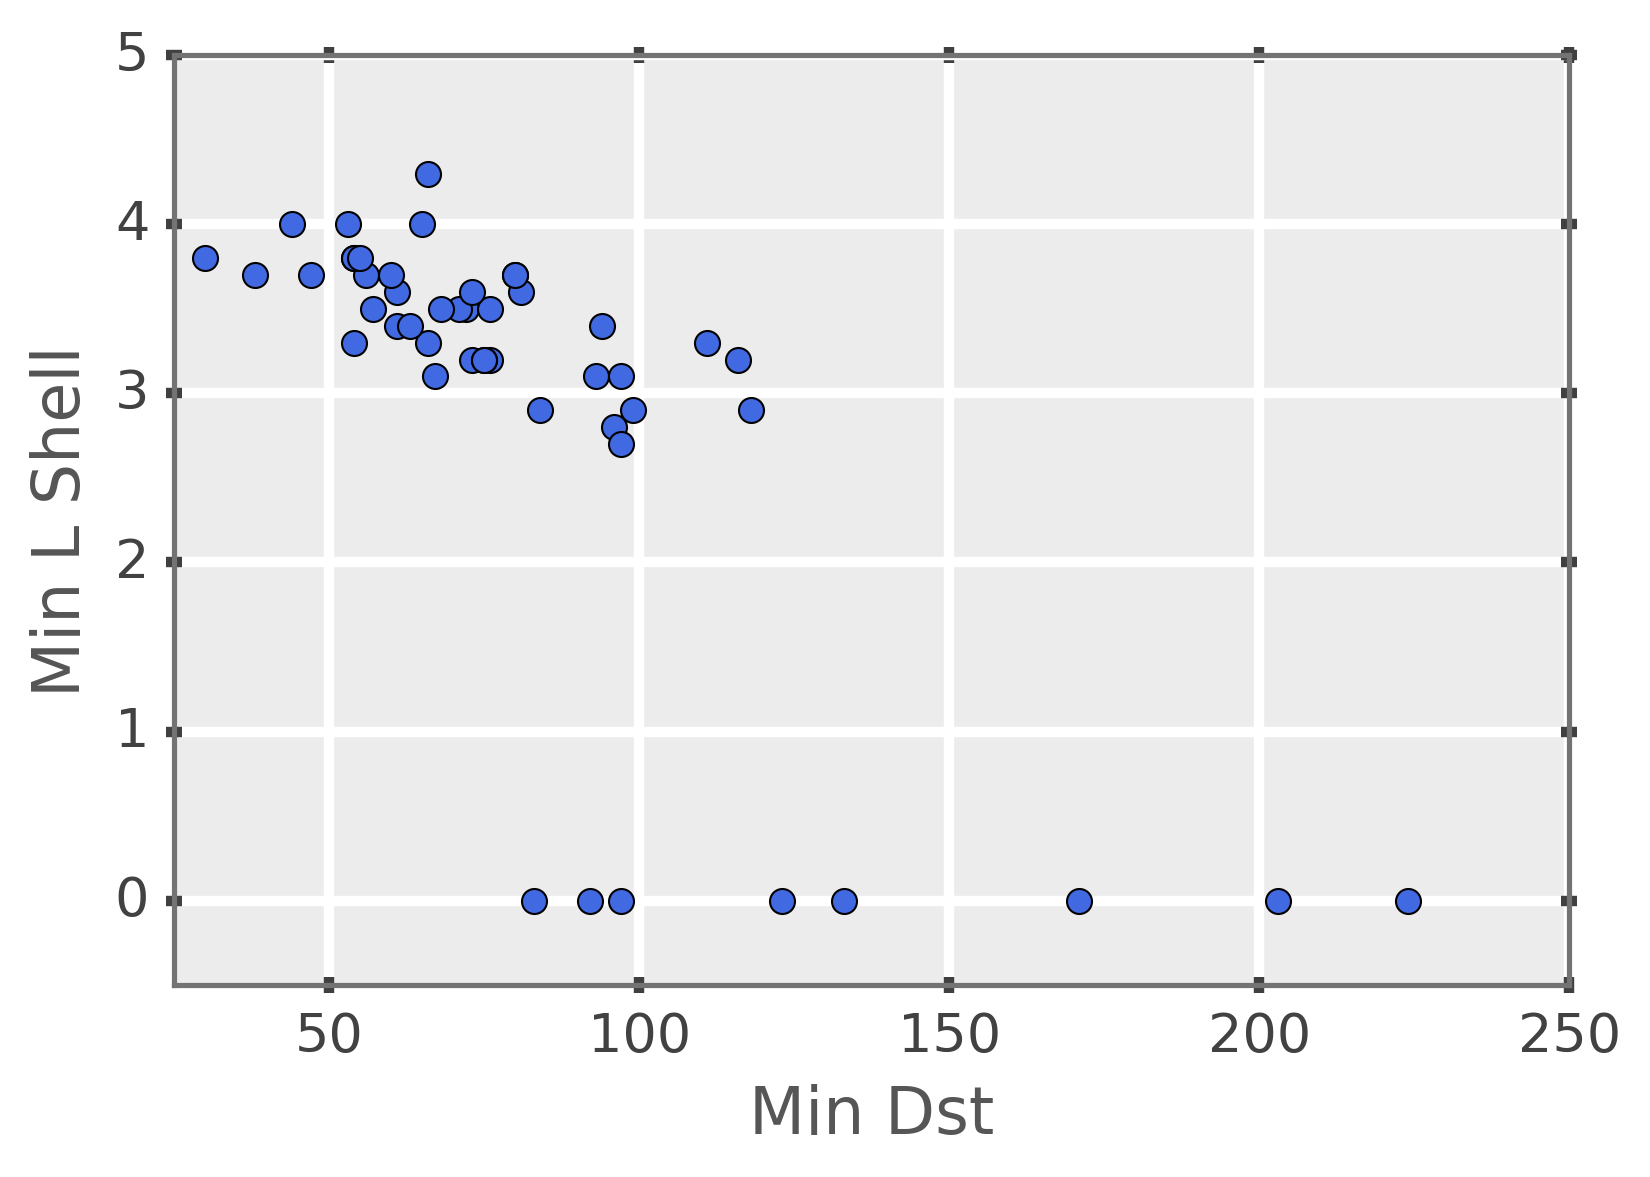

In [5]:
plt.plot(dst, minL, 'o')
plt.xlim((25, 250))
plt.ylim((-0.5, 5.0))
plt.xlabel('Min Dst')
plt.ylabel('Min L Shell')

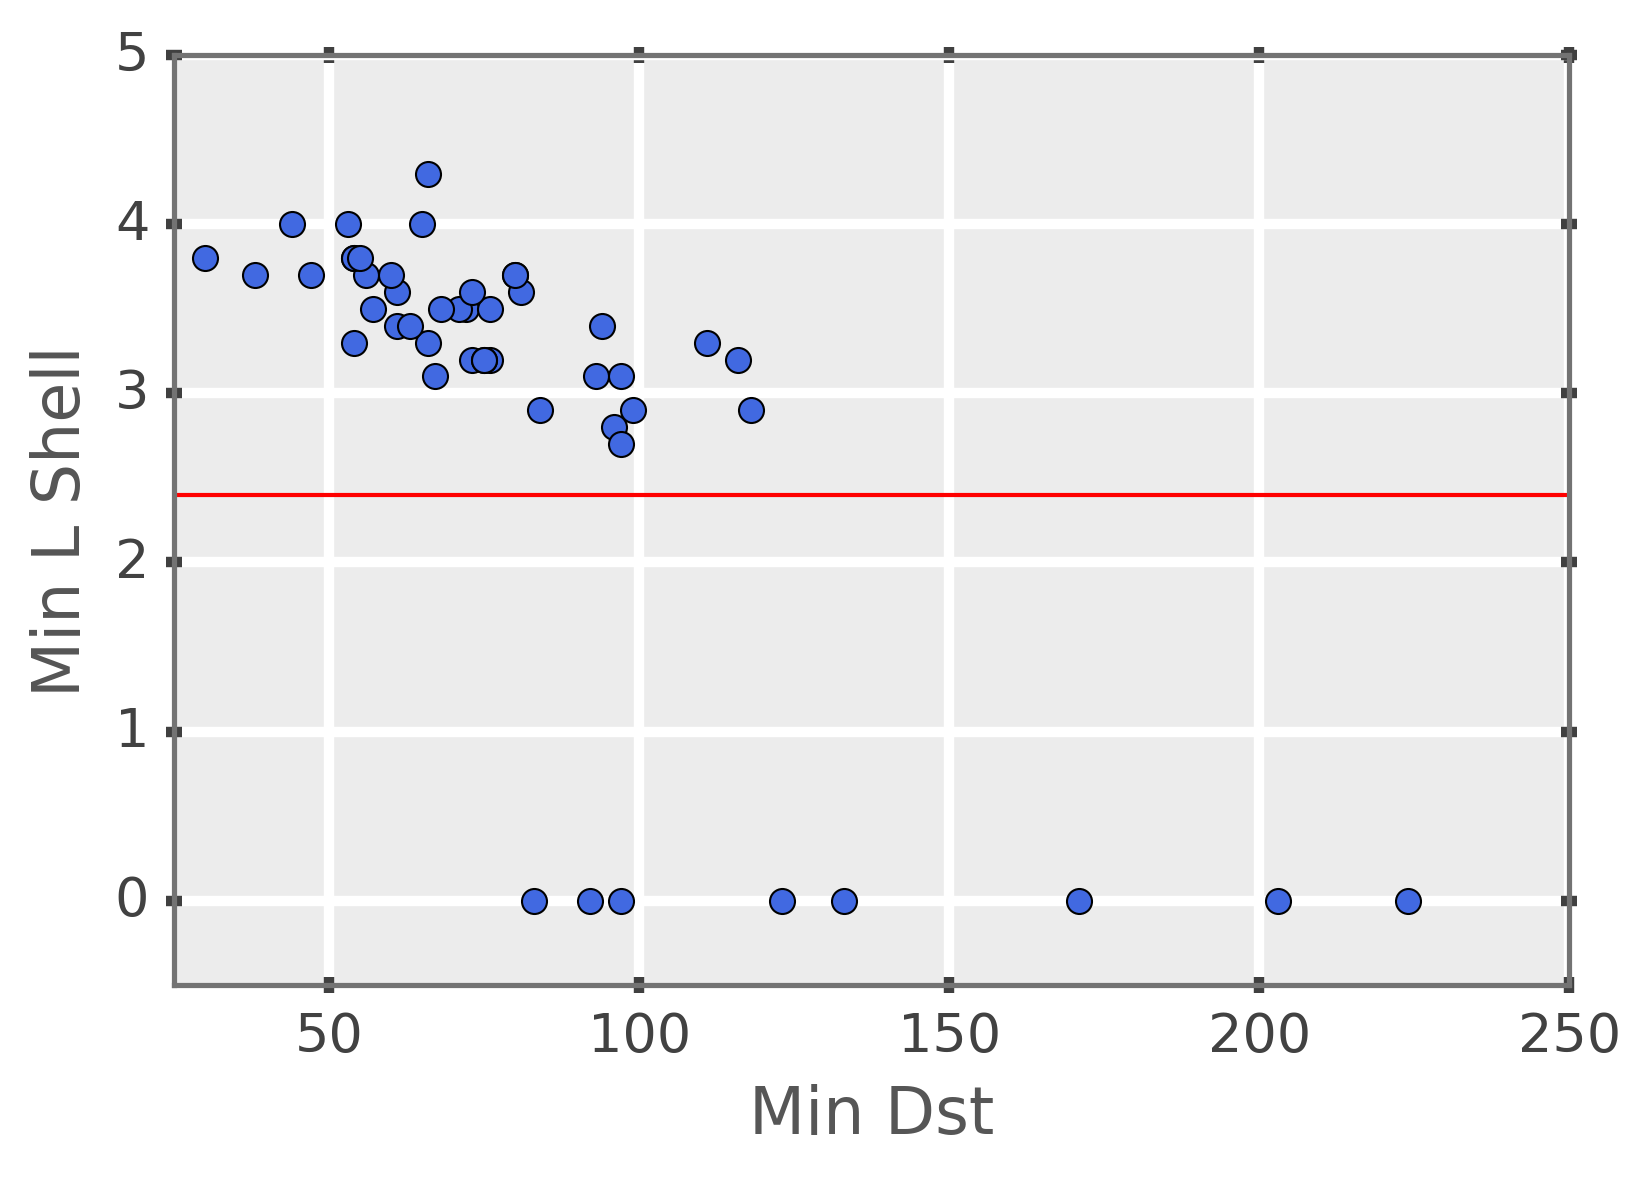

In [6]:
plt.plot(dst, minL, 'o')
plt.xlim((25, 250))
plt.ylim((-0.5, 5.0))
plt.xlabel('Min Dst')
plt.ylabel('Min L Shell')
# for v in dst_bins:
#     plt.axvline(v, lw=0.5)
plt.axhline(2.4, c='r', lw=1)

## Oberved Data:
* n_pts : the number of points in each of the 25nT wide Dst bins
* successes : the number of events in each bin where the slot was filled (Min L = 2.3)
* dst_bins_centers : the centers of the Dst bins

In [7]:
# define invlogit function
def invlogit(x):
  return pymc.exp(x) / (1 + pymc.exp(x))

Setup the Bayesian model accorind to the description above. Run the Markov chain monte carlo (MCMC) to sample the posterior distributions for $\alpha$ and $\beta$

In [8]:
# define priors
# these are wide uninformative priors
# alpha = pymc.Normal('alpha', mu=0, tau=1.0/5**2)
# beta = pymc.Normal('beta', mu=0, tau=1.0/10**2)
alpha = pymc.Uniform('alpha', -500, 100, value = 1e-2)
beta = pymc.Uniform('beta', -100, 100, value = 1e-2)


# cannot feed in zero events
ind = n_events > 0
print(n_events.shape, dst_bins_centers.shape, success.shape, )

# define likelihood
p = pymc.InvLogit('p', alpha + beta*dst_bins_centers[ind])
print('n_events', n_events[ind], 'p', p.value, 'success', success[ind], )
y = pymc.Binomial('y_obs', n=n_events[ind], p=p, value=success[ind], observed=True)



(274,) (274,) (274,)
n_events [ 1.  1.  1.  1.  1.  3.  1.  1.  1.  1.  2.  1.  1.  2.  1.  1.  1.  1.
  2.  2.  2.  2.  1.  1.  1.  1.  1.  1.  1.  3.  1.  1.  1.  1.  1.  1.
  1.  1.  1.] p [ 0.57810523  0.59748577  0.61182737  0.61892785  0.63297478  0.63529485
  0.63760865  0.6399161   0.64221709  0.64908052  0.65135486  0.65588284
  0.66038267  0.66262184  0.66485373  0.66707828  0.6737071   0.67590153
  0.67808825  0.6824383   0.6846015   0.69317395  0.69529667  0.69951723
  0.70161495  0.71808858  0.72010853  0.72211961  0.72611498  0.7280992
  0.7320405   0.75491499  0.7640476   0.76763412  0.77643314  0.79331099
  0.84877175  0.88544142  0.90508095] success [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.
  1.  1.  1.]


In [9]:
# inference
m = pymc.Model([alpha, beta, y])
mc = pymc.MCMC(m)
mc.sample(iter=500000, burn=1000, burn_till_tuned=True, thin=110)

 [-----------------101%-----------------] 510134 of 504000 complete in 59.5 sec

Make diagnostic plots of the posteriour distributions as created using MCMC.  

Plotting beta
Plotting alpha


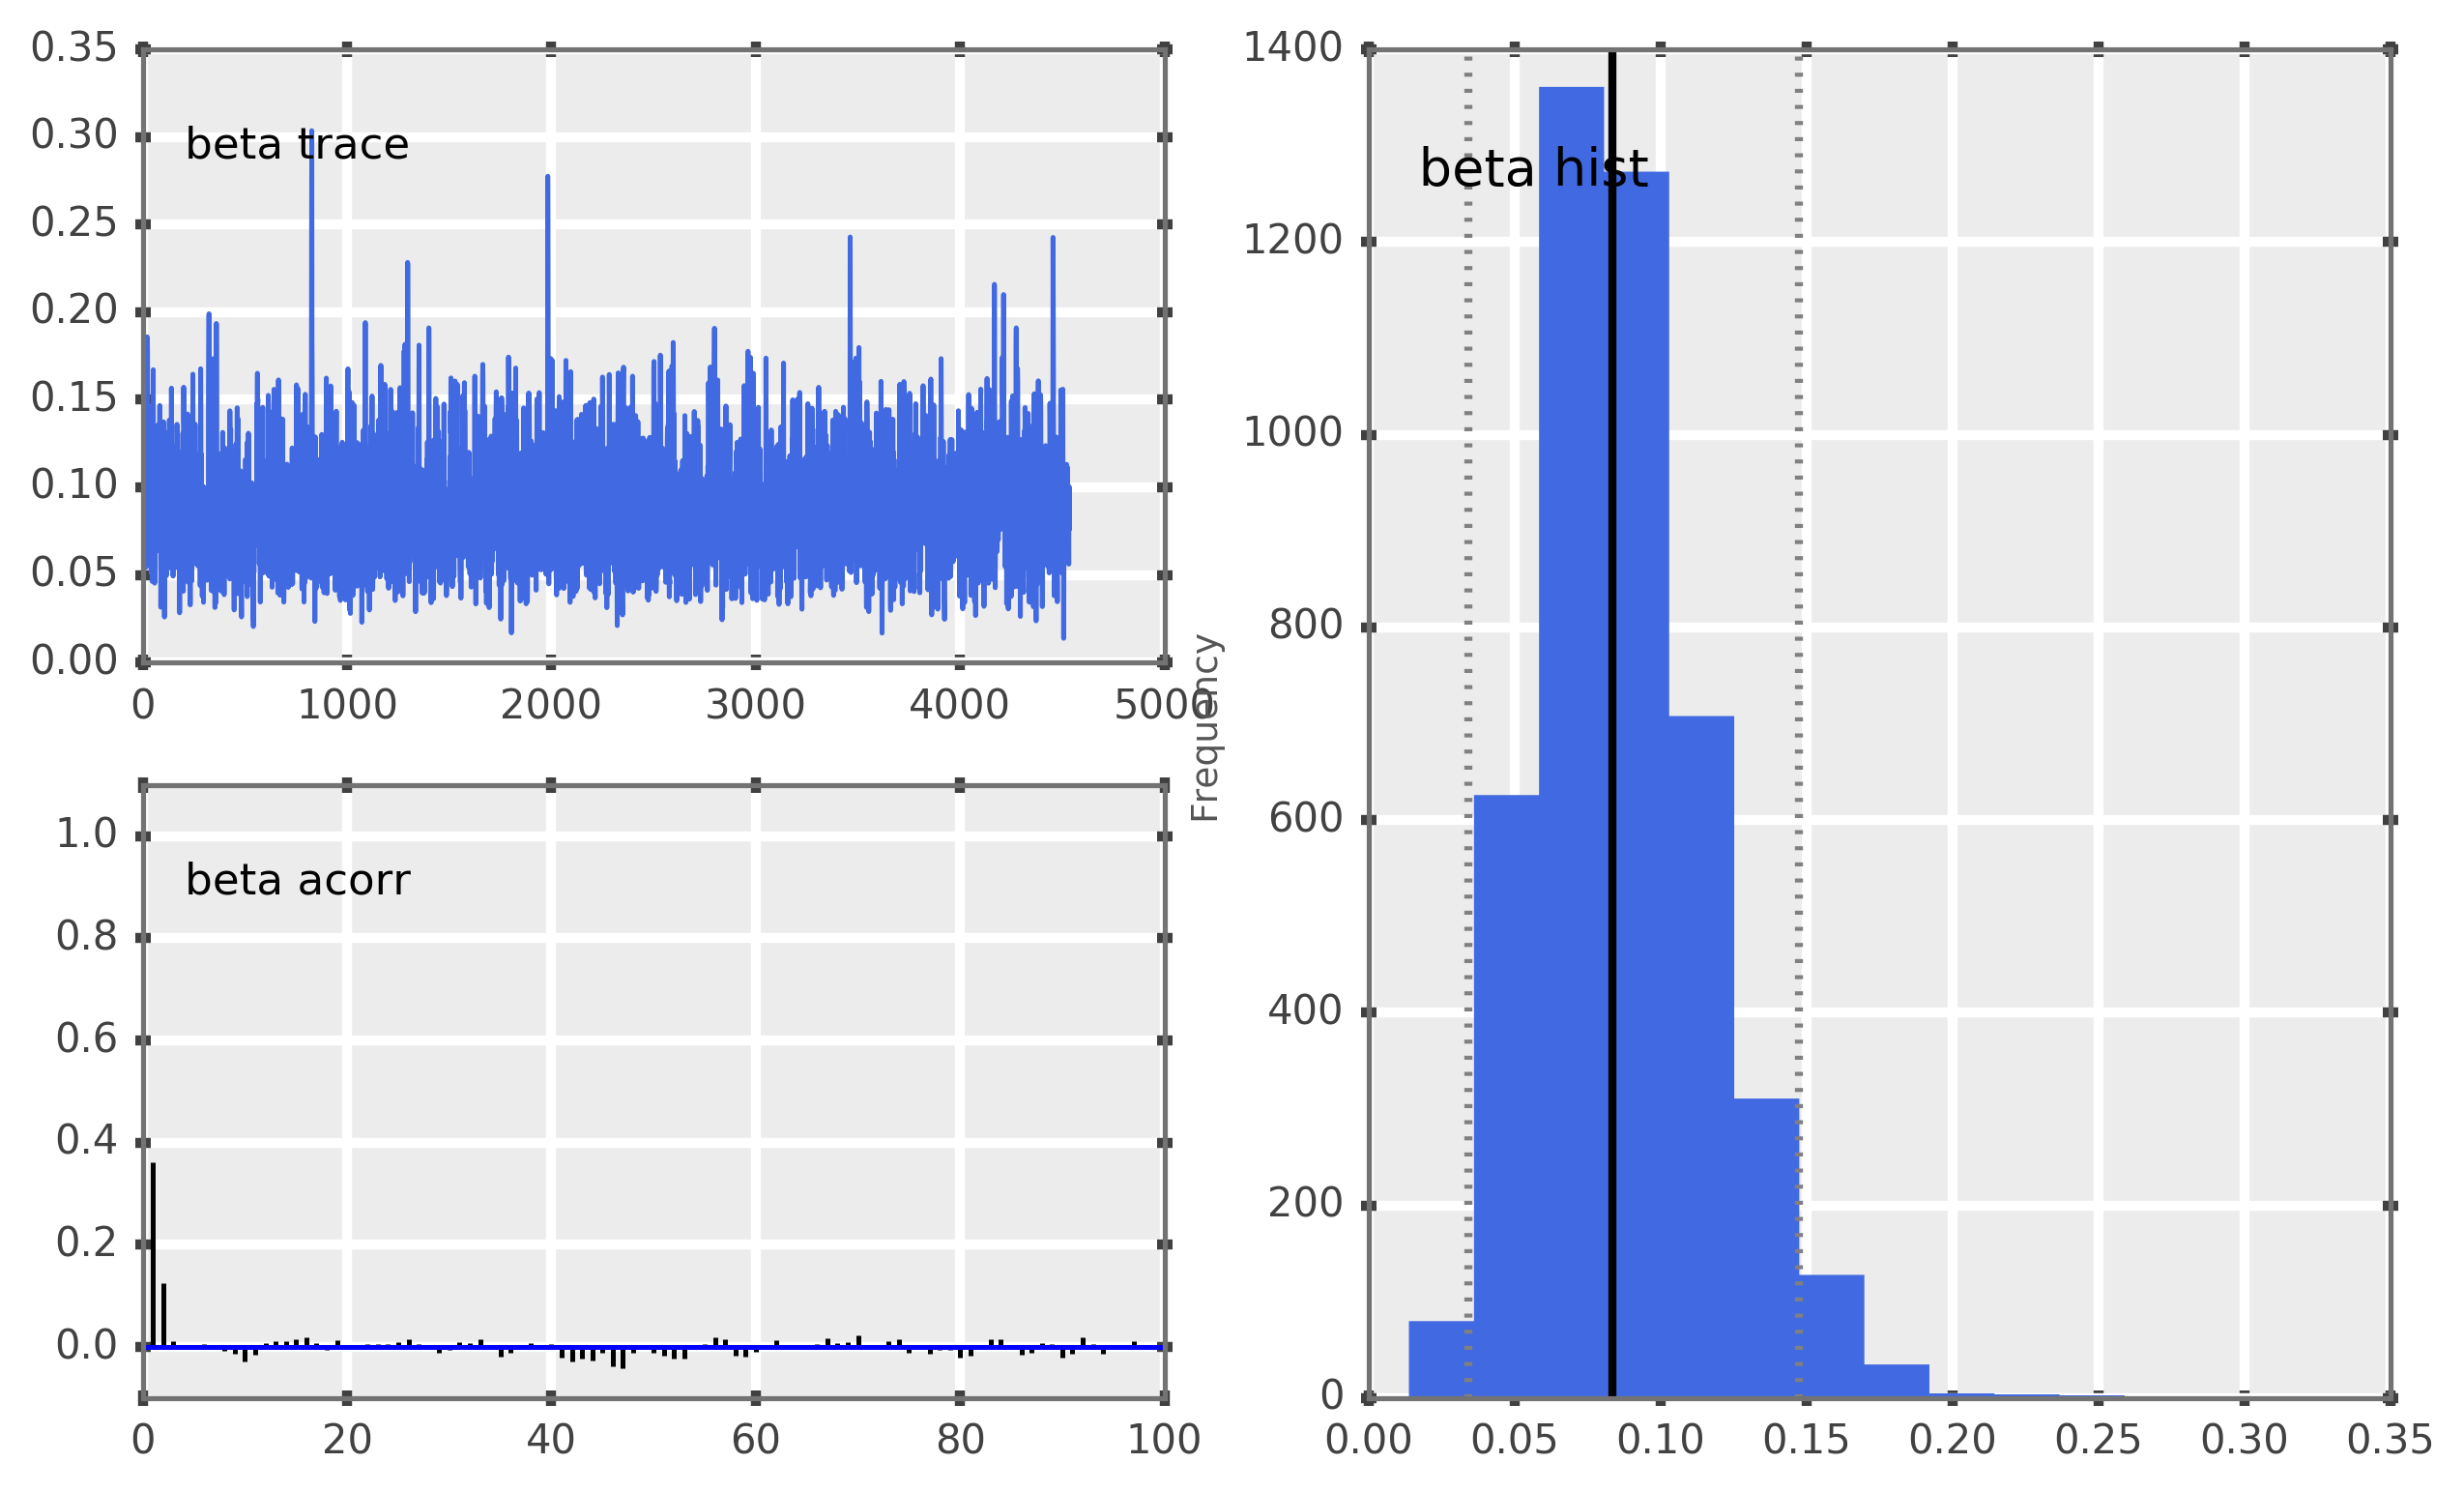

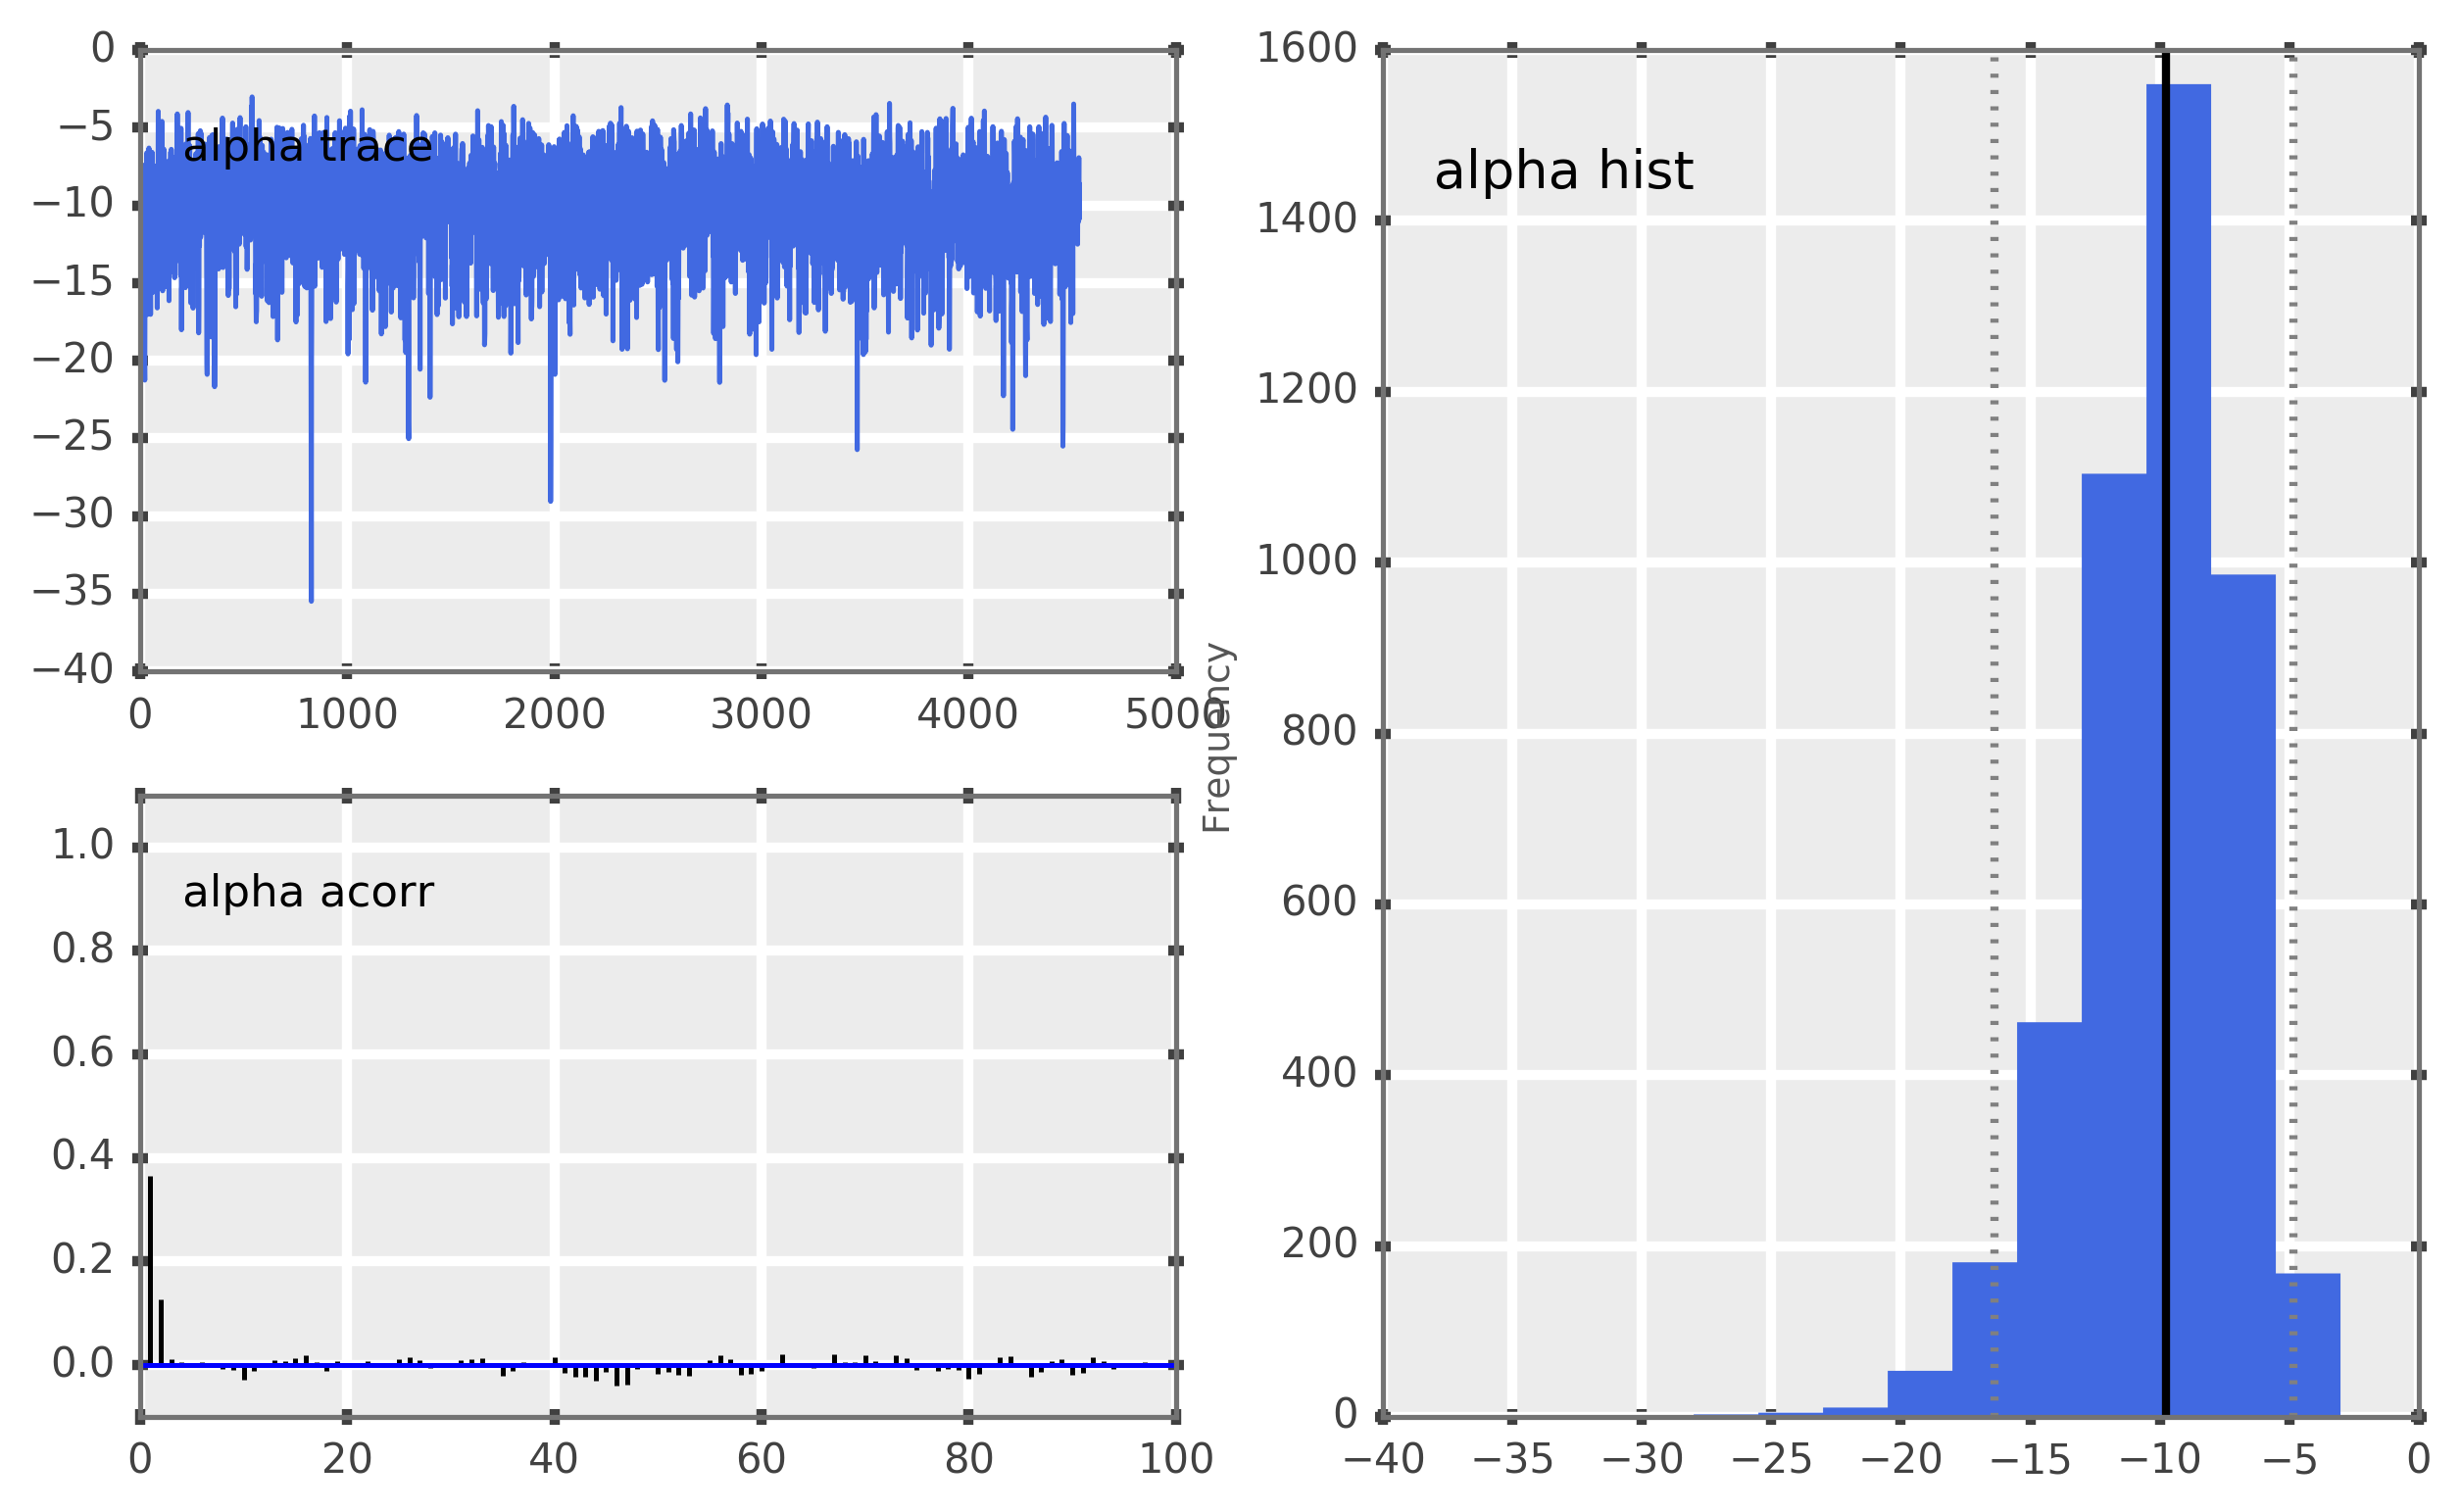

In [10]:
pymc.Matplot.plot(mc)

In [11]:
pprint(mc.stats())

{'alpha': {'95% HPD interval': array([-16.38770062,  -4.82836828]),
           'mc error': 0.067223018211041749,
           'mean': -10.136199539358115,
           'n': 4536,
           'quantiles': {2.5: -17.162353898547902,
                         25: -11.865898192132253,
                         50: -9.744995107057921,
                         75: -7.9813187669557744,
                         97.5: -5.2352460927722095},
           'standard deviation': 3.0812127492536399},
 'beta': {'95% HPD interval': array([ 0.03407035,  0.14754555]),
          'mc error': 0.00065270159763237327,
          'mean': 0.087325840017834874,
          'n': 4536,
          'quantiles': {2.5: 0.038703952503961858,
                        25: 0.066520339607558487,
                        50: 0.083542141275861709,
                        75: 0.10441694740984872,
                        97.5: 0.156006815243832},
          'standard deviation': 0.030046992609180707}}


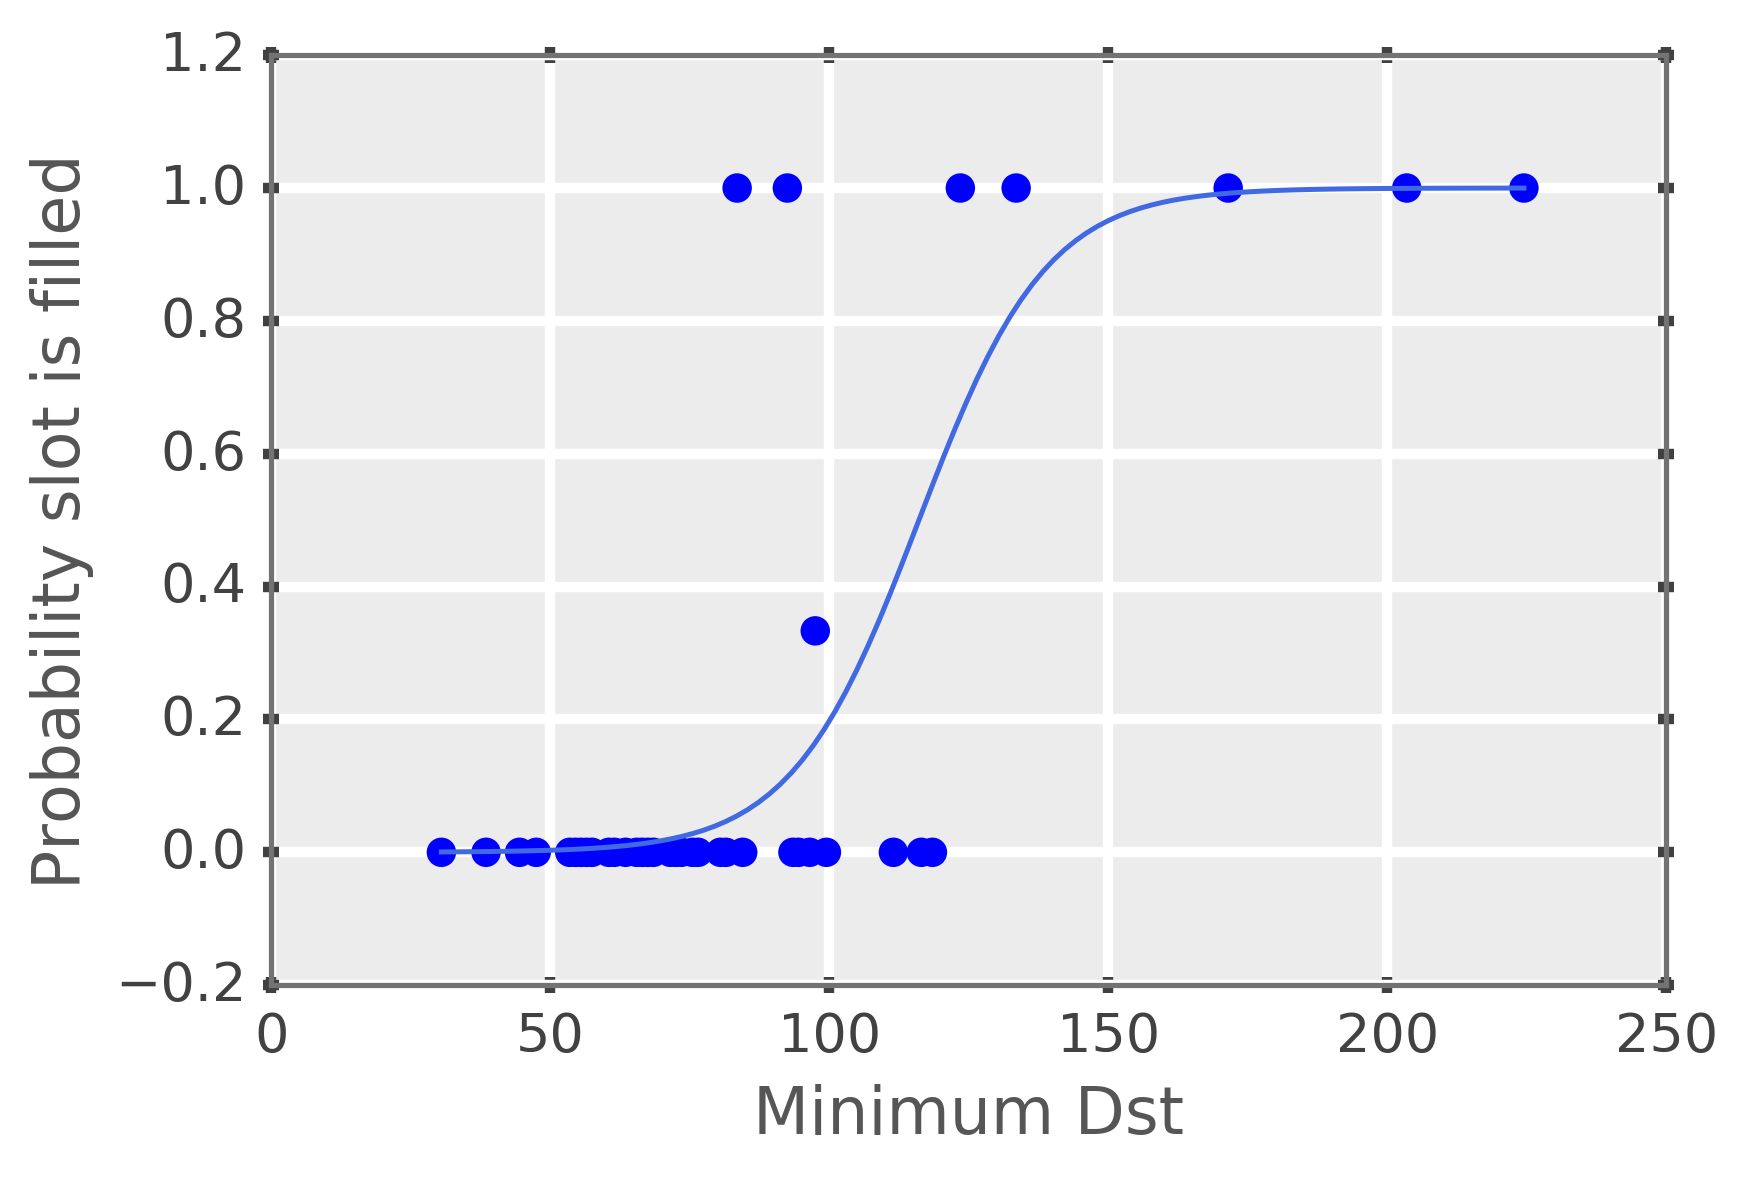

In [12]:
xp = np.linspace(dst_bins_centers[ind].min(), dst_bins_centers[ind].max(), 100)
a = alpha.stats()['mean']
b = beta.stats()['mean']
y_val = invlogit(a + b*xp).value
plt.plot(xp, y_val)
plt.scatter(dst_bins_centers[ind], success[ind]/n_events[ind], s=50);
plt.xlabel('Minimum Dst')
plt.ylabel('Probability slot is filled')
plt.gca().ticklabel_format(useOffset=False)


## Predictions based on this model

In [13]:
# get the minimum Dst where 99% should be successes
for percentage in [50,75,90,95,99]:
    ind99 = y_val >= percentage/100
    minDst99 = xp[ind99][0]
    print('At a minimum Dst of {0:0.0f}nT it is predicted to have a {1}% percent of a slot filling'.format(minDst99, percentage))

At a minimum Dst of 117nT it is predicted to have a 50% percent of a slot filling
At a minimum Dst of 130nT it is predicted to have a 75% percent of a slot filling
At a minimum Dst of 142nT it is predicted to have a 90% percent of a slot filling
At a minimum Dst of 150nT it is predicted to have a 95% percent of a slot filling
At a minimum Dst of 170nT it is predicted to have a 99% percent of a slot filling


The 20160906 data gave these results:

At a minimum Dst of 100nT it is predicted to have a 50% percent of a slot filling

At a minimum Dst of 105nT it is predicted to have a 75% percent of a slot filling

At a minimum Dst of 111nT it is predicted to have a 90% percent of a slot filling

At a minimum Dst of 114nT it is predicted to have a 95% percent of a slot filling

At a minimum Dst of 123nT it is predicted to have a 99% percent of a slot filling

## Plot up many lines for a feel at uncertantity

In [14]:
# one should be able to get estimates of the line uncertainity
ilu = np.empty((1000, len(xp)), dtype=float)
for ii, v in enumerate(np.random.random_integers(0, len(alpha.trace[:])-1, 1000)):
  ilu[ii] = invlogit(alpha.trace[:][v] + beta.trace[:][v]*xp).value


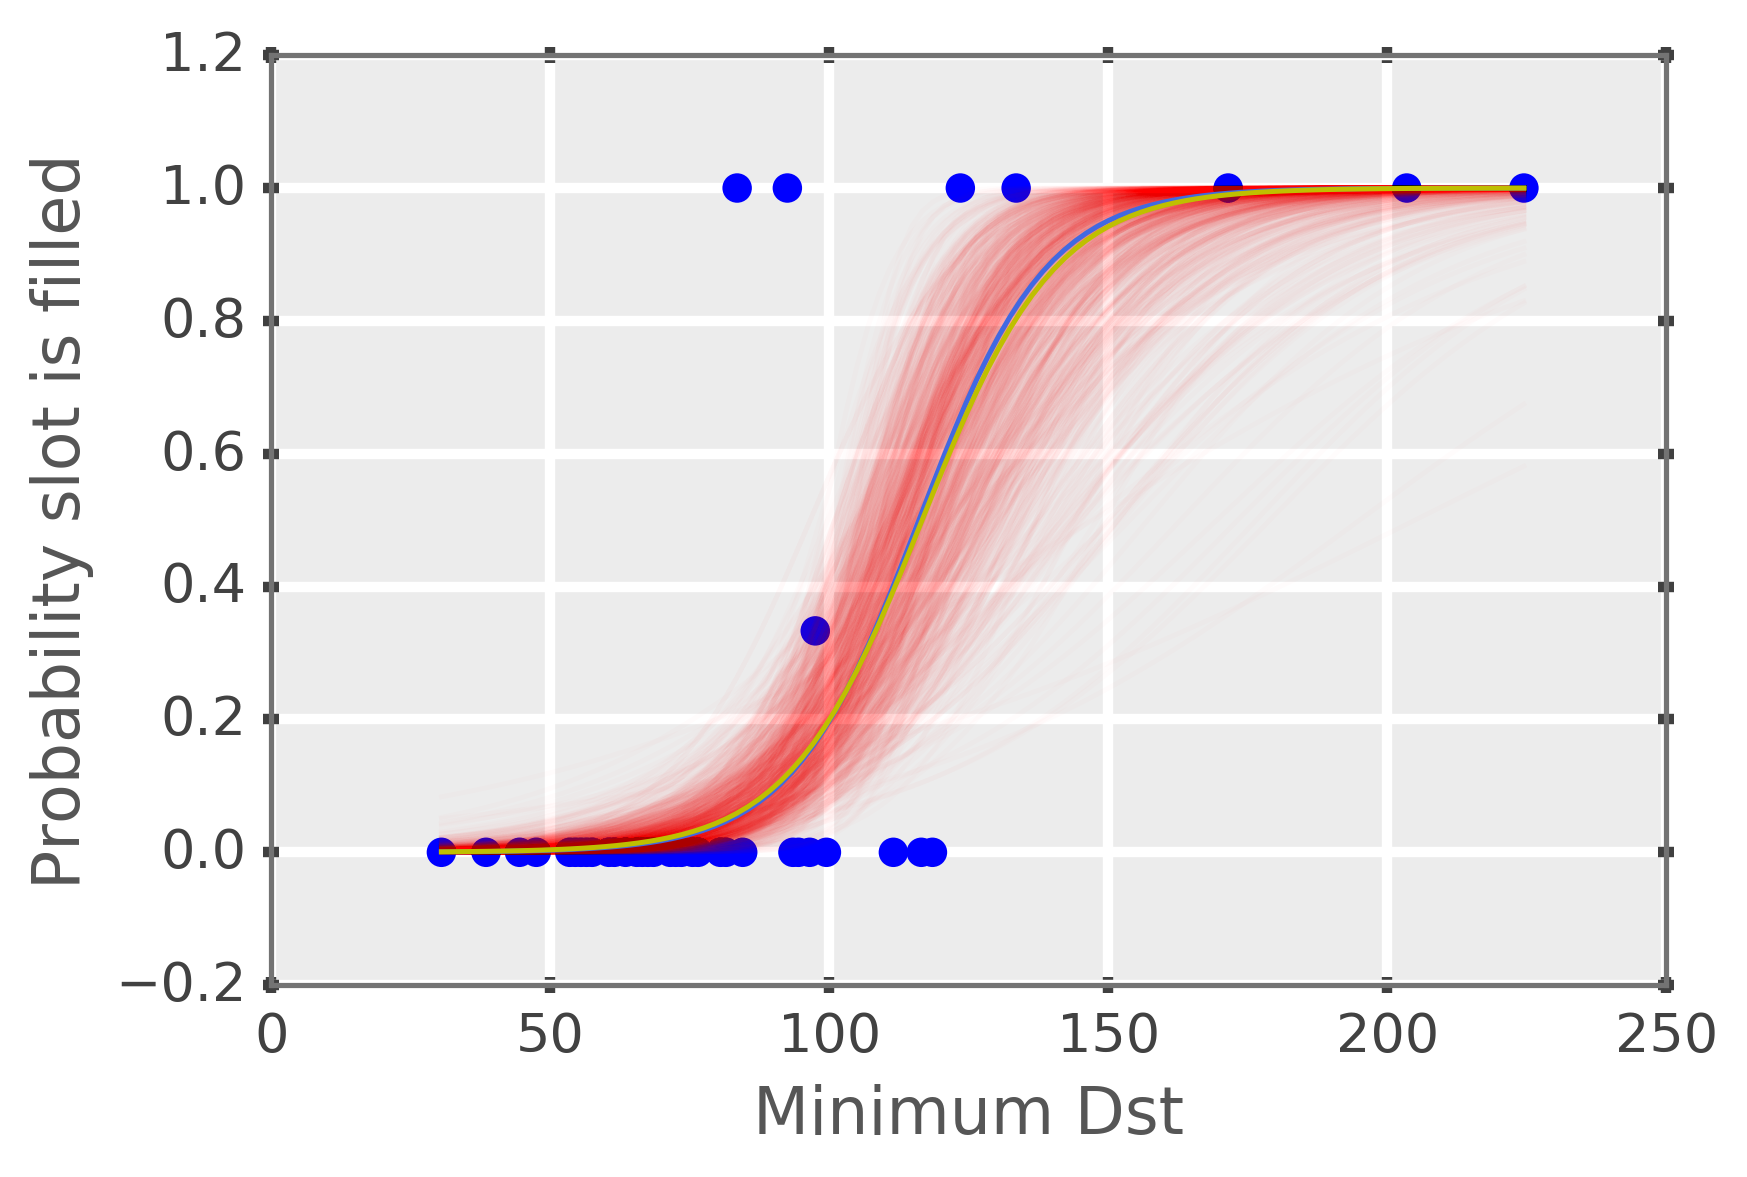

In [15]:
xp = np.linspace(dst_bins_centers[ind].min(), dst_bins_centers[ind].max(), 100)
for v in ilu:
  plt.plot(xp, v, alpha=.01, c='r')


a = alpha.stats()['mean']
b = beta.stats()['mean']
plt.plot(xp, invlogit(a + b*xp).value)

a = alpha.stats()['quantiles'][50]
b = beta.stats()['quantiles'][50]
plt.plot(xp, invlogit(a + b*xp).value, c='y')


plt.scatter(dst_bins_centers[ind], success[ind]/n_events[ind], s=50);
plt.xlabel('Minimum Dst')
plt.ylabel('Probability slot is filled')

Same as previous figure with the red lines overlayed as 100 joint draws from the model posterior in order to show spread. 

# Do the analysis again in Dst bins (10nT)



In [16]:
# make bins in Dst
dst_bins = np.arange(25, 300, 10)
print(dst_bins)
dst_bins_centers = np.asarray([dst_bins[:-1] + np.diff(dst_bins)/2]).T[:,0]
print(dst_bins_centers, dst_bins_centers.shape)
n_events_dig = np.digitize(dst, dst_bins)
print(n_events_dig)
n_events = np.zeros(len(dst_bins)-1)
success = np.zeros_like(n_events)
for i, v in enumerate(np.unique(n_events_dig)):
    n_events[v-1] = np.sum(n_events_dig==v)
    success[v-1] = np.sum(minL[n_events_dig==v] <= 2.3)
print(n_events)
print(success)


[ 25  35  45  55  65  75  85  95 105 115 125 135 145 155 165 175 185 195
 205 215 225 235 245 255 265 275 285 295]
[  30.   40.   50.   60.   70.   80.   90.  100.  110.  120.  130.  140.
  150.  160.  170.  180.  190.  200.  210.  220.  230.  240.  250.  260.
  270.  280.  290.] (27,)
[ 3  3 11  4  5  4 10  5  8  5  2  3  5  6  5 10  7  6  5  2  6  6  5  8  3
  3 20  6  6  5 18  5  4  4  6  7  8  6 10  8  4 15  9  7  4  8  4  1  6]
[ 1.  2.  5.  7.  9.  9.  3.  5.  1.  3.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  1.  1.  1.  0.  1.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  0.  0.  0.  0.]


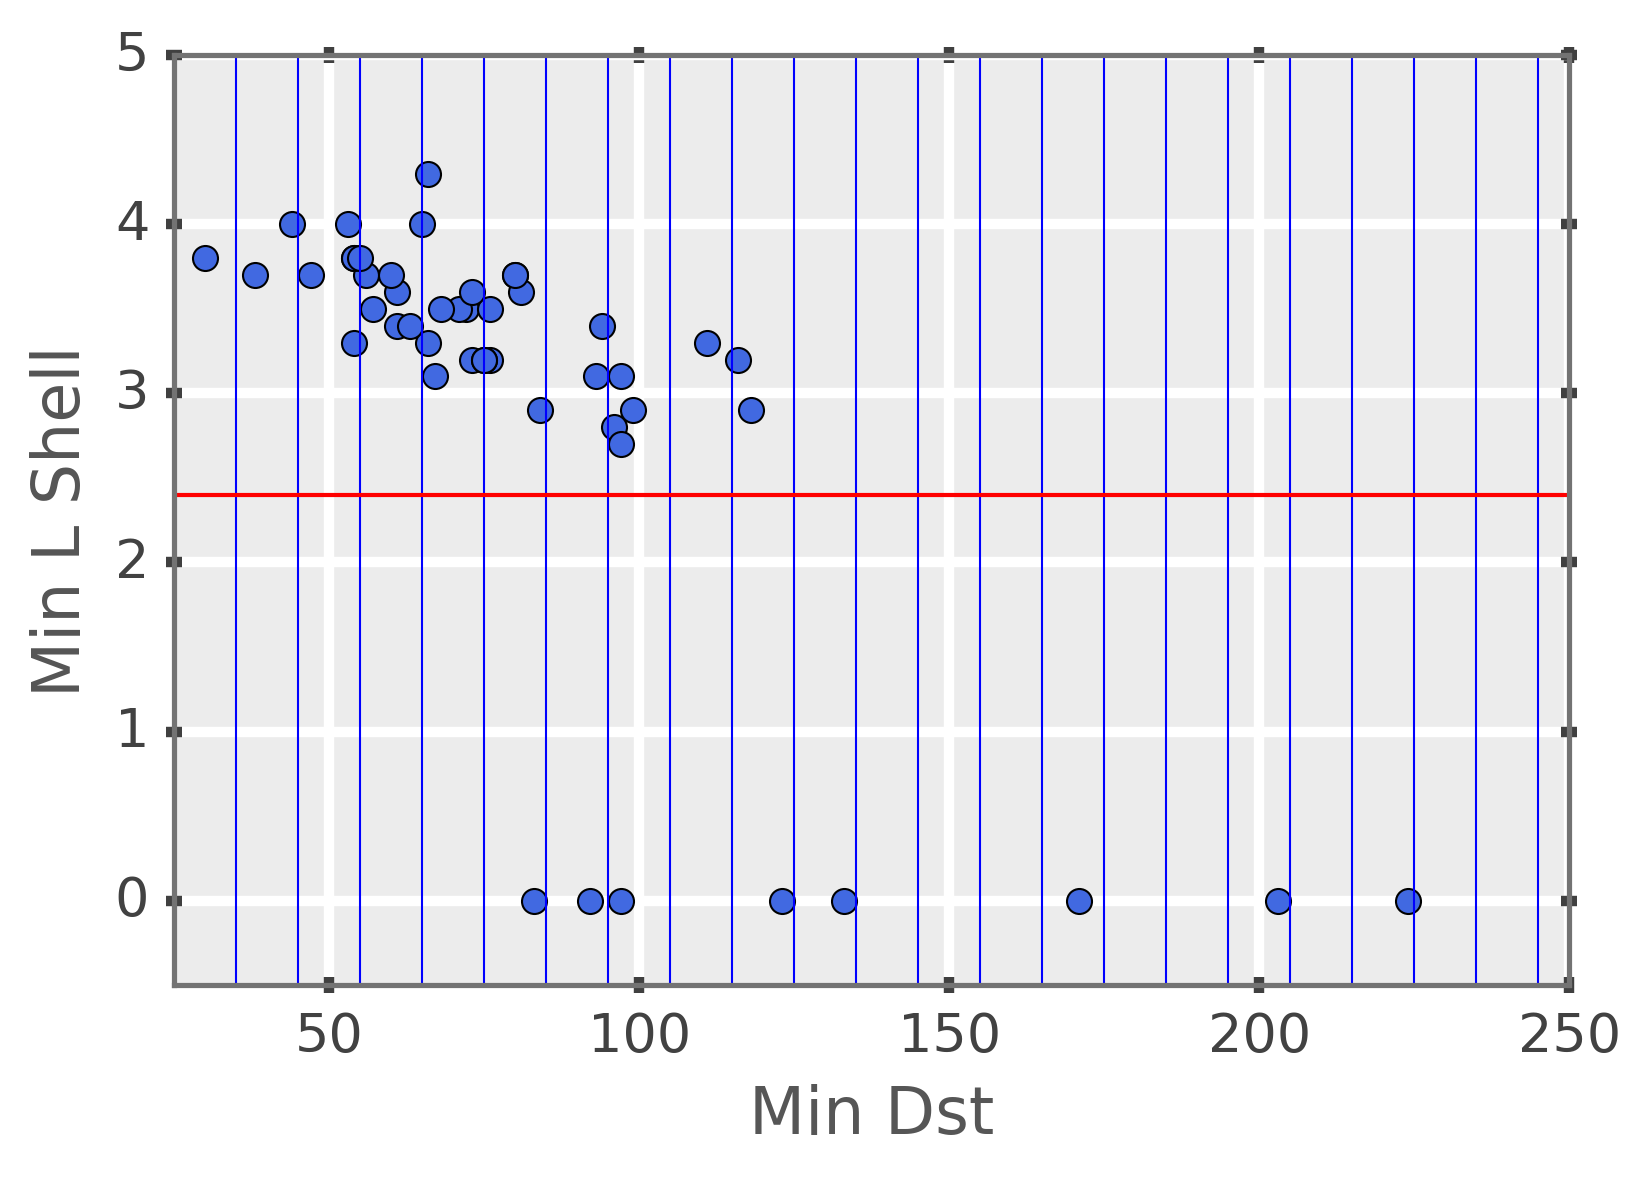

In [17]:
plt.plot(dst, minL, 'o')
plt.xlim((25, 250))
plt.ylim((-0.5, 5.0))
plt.xlabel('Min Dst')
plt.ylabel('Min L Shell')
for v in dst_bins:
    plt.axvline(v, lw=0.5)
plt.axhline(2.4, c='r', lw=1)

In [18]:
# define priors
# these are wide uninformative priors
# alpha = pymc.Normal('alpha', mu=0, tau=1.0/5**2)
# beta = pymc.Normal('beta', mu=0, tau=1.0/10**2)
alpha = pymc.Uniform('alpha', -500, 100, value = 1e-2)
beta = pymc.Uniform('beta', -100, 100, value = 1e-2)


# cannot feed in zero events
ind = n_events > 0
print(n_events.shape, dst_bins_centers.shape, success.shape, )

# define likelihood
p = pymc.InvLogit('p', alpha + beta*dst_bins_centers[ind])
print('n_events', n_events[ind], 'p', p.value, 'success', success[ind], )
y = pymc.Binomial('y_obs', n=n_events[ind], p=p, value=success[ind], observed=True)



(27,) (27,) (27,)
n_events [ 1.  2.  5.  7.  9.  9.  3.  5.  1.  3.  1.  1.  1.  1.] p [ 0.57688526  0.60108788  0.62480647  0.6479408   0.67040116  0.6921095
  0.71300016  0.73302015  0.75212911  0.77029895  0.78751316  0.84683628
  0.88184302  0.90114393] success [ 0.  0.  0.  0.  0.  1.  1.  1.  0.  1.  1.  1.  1.  1.]


In [19]:
# inference
m = pymc.Model([alpha, beta, y])
mc = pymc.MCMC(m)
mc.sample(iter=500000, burn=1000, burn_till_tuned=True, thin=110)

 [-----------------100%-----------------] 508725 of 504000 complete in 56.0 sec

Plotting alpha
Plotting beta
{'alpha': {'95% HPD interval': array([-14.81910998,  -4.04165442]),
           'mc error': 0.062906676752426879,
           'mean': -9.4839225349246377,
           'n': 4536,
           'quantiles': {2.5: -16.069391188641315,
                         25: -11.25613485489335,
                         50: -9.1402563050491388,
                         75: -7.3738176471742261,
                         97.5: -4.7323392890607918},
           'standard deviation': 2.9190991419329935},
 'beta': {'95% HPD interval': array([ 0.0309256 ,  0.13548364]),
          'mc error': 0.00061917678936076743,
          'mean': 0.080488074051642475,
          'n': 4536,
          'quantiles': {2.5: 0.034291737072569731,
                        25: 0.060029588496779092,
                        50: 0.077635480831043546,
                        75: 0.097691098941976626,
                        97.5: 0.14258206694414038},
          'standard deviation': 0.028166593927755217}}


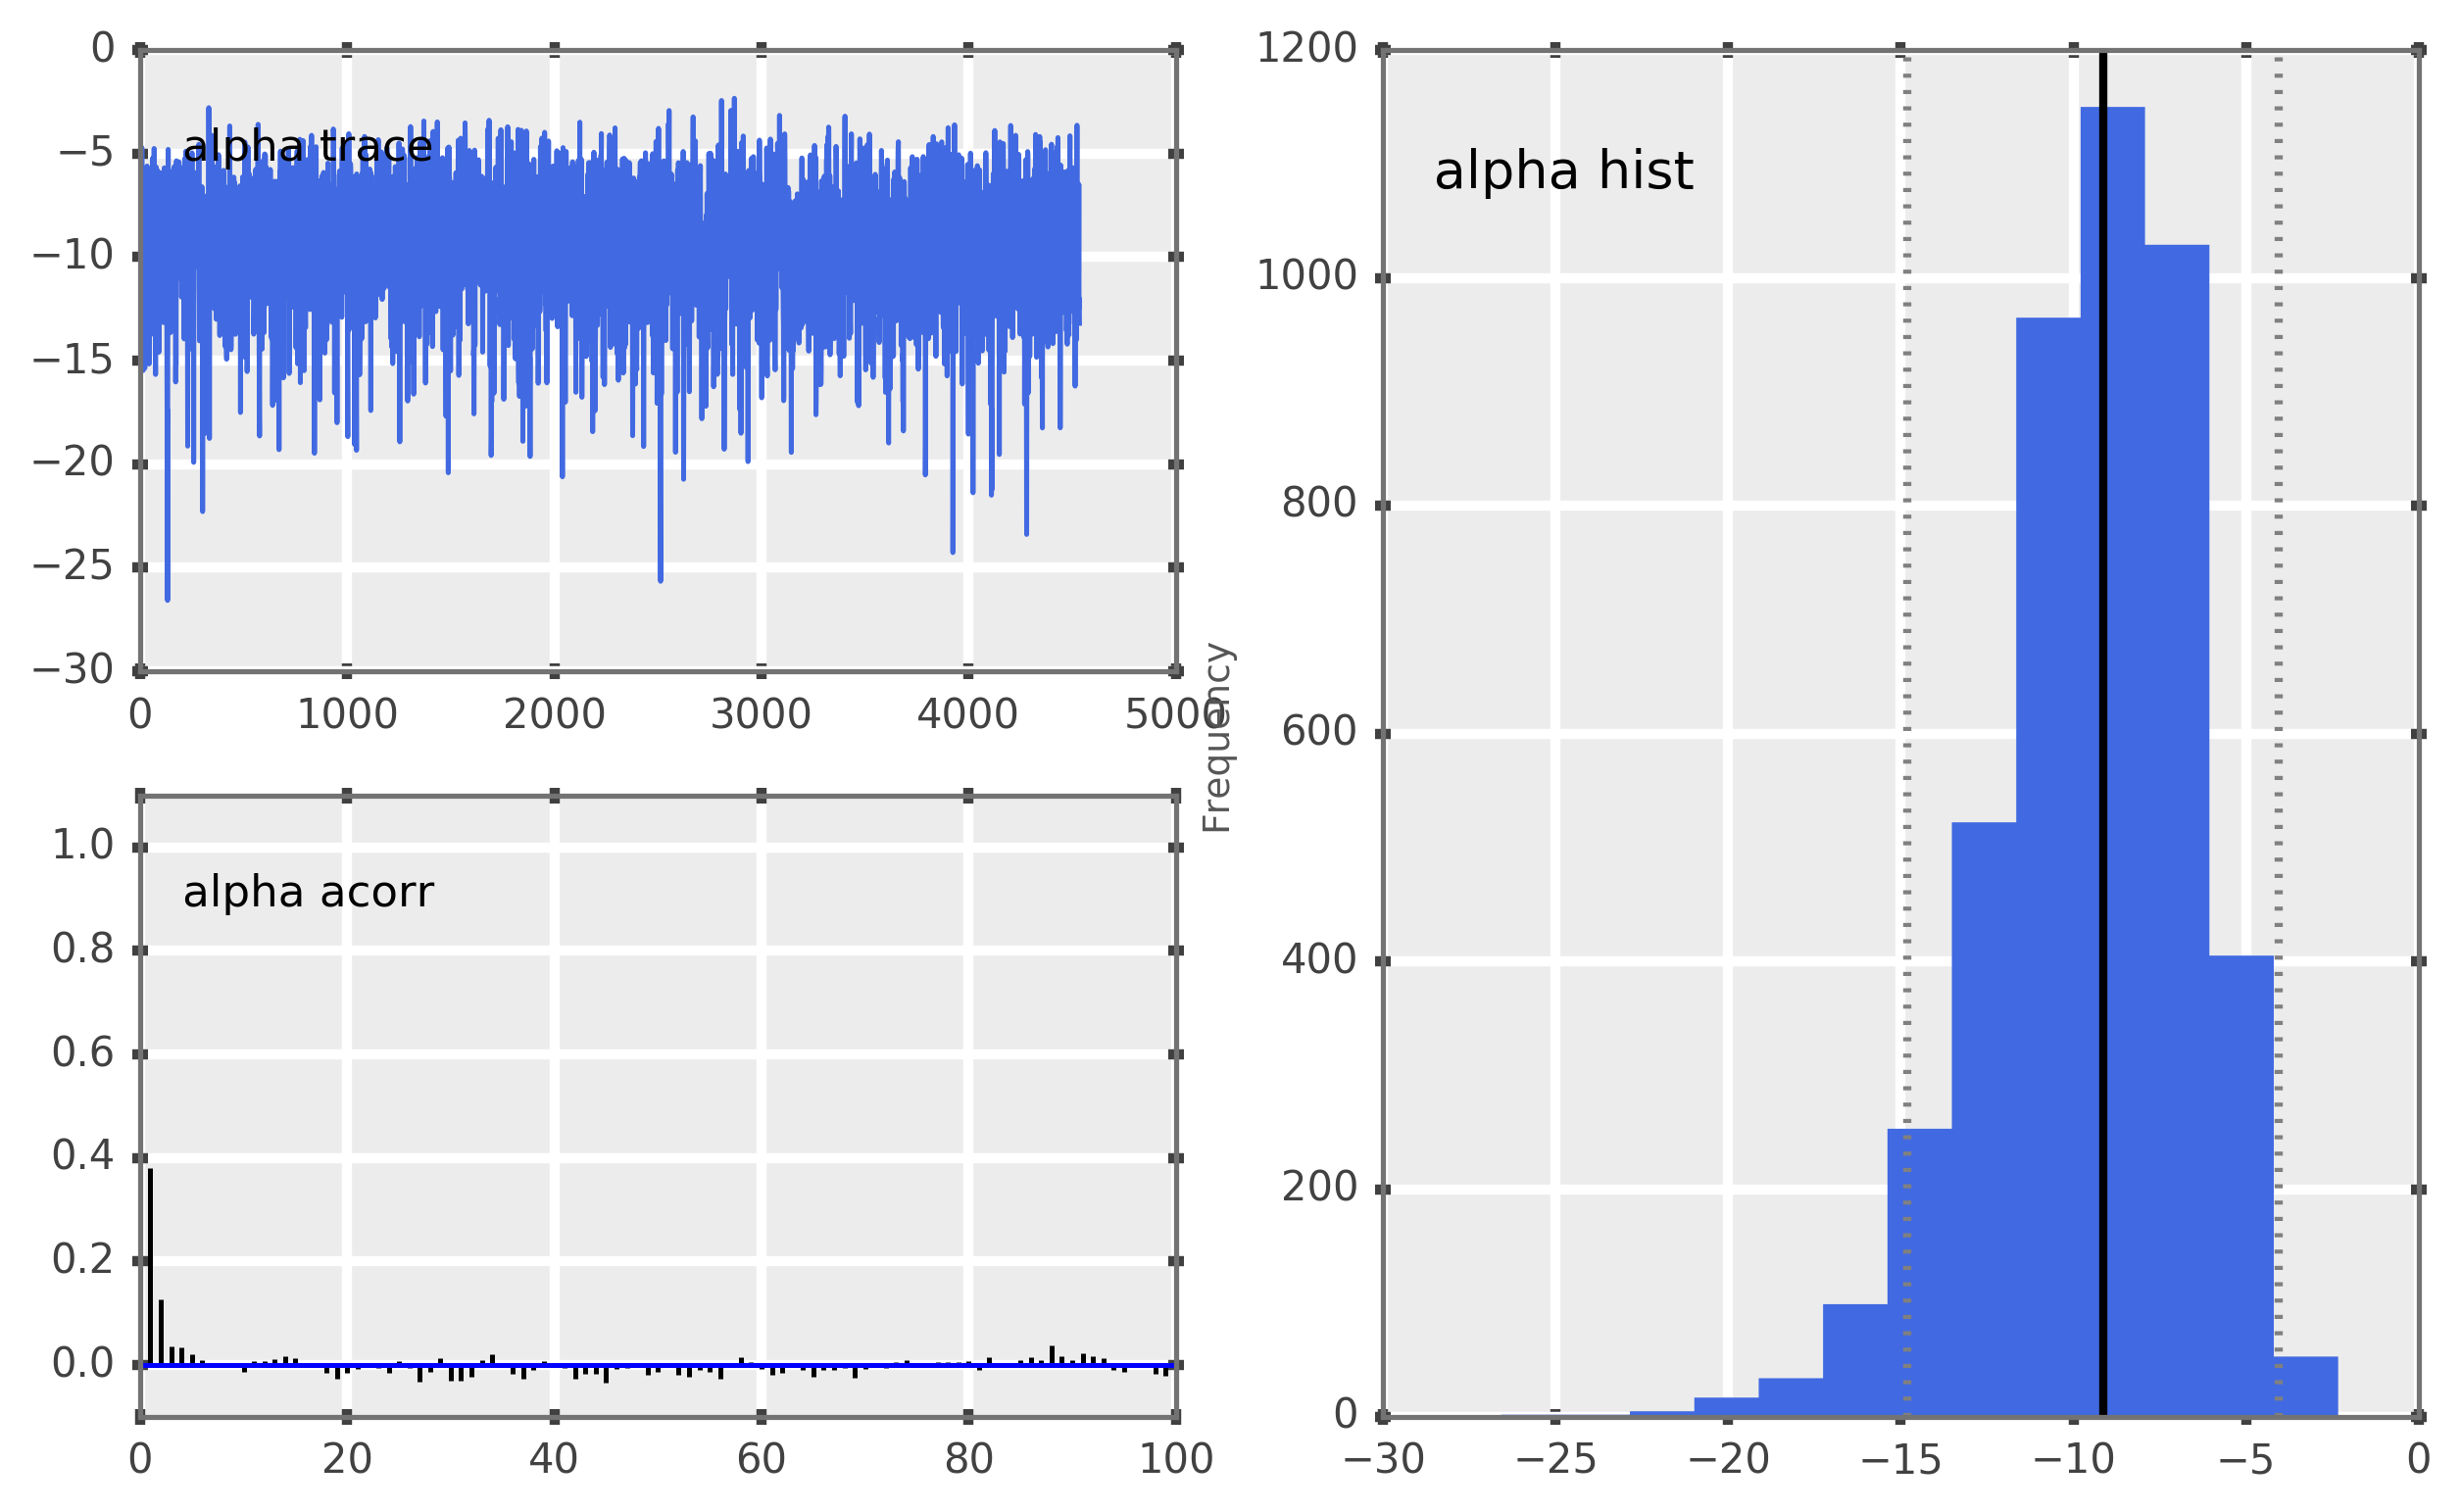

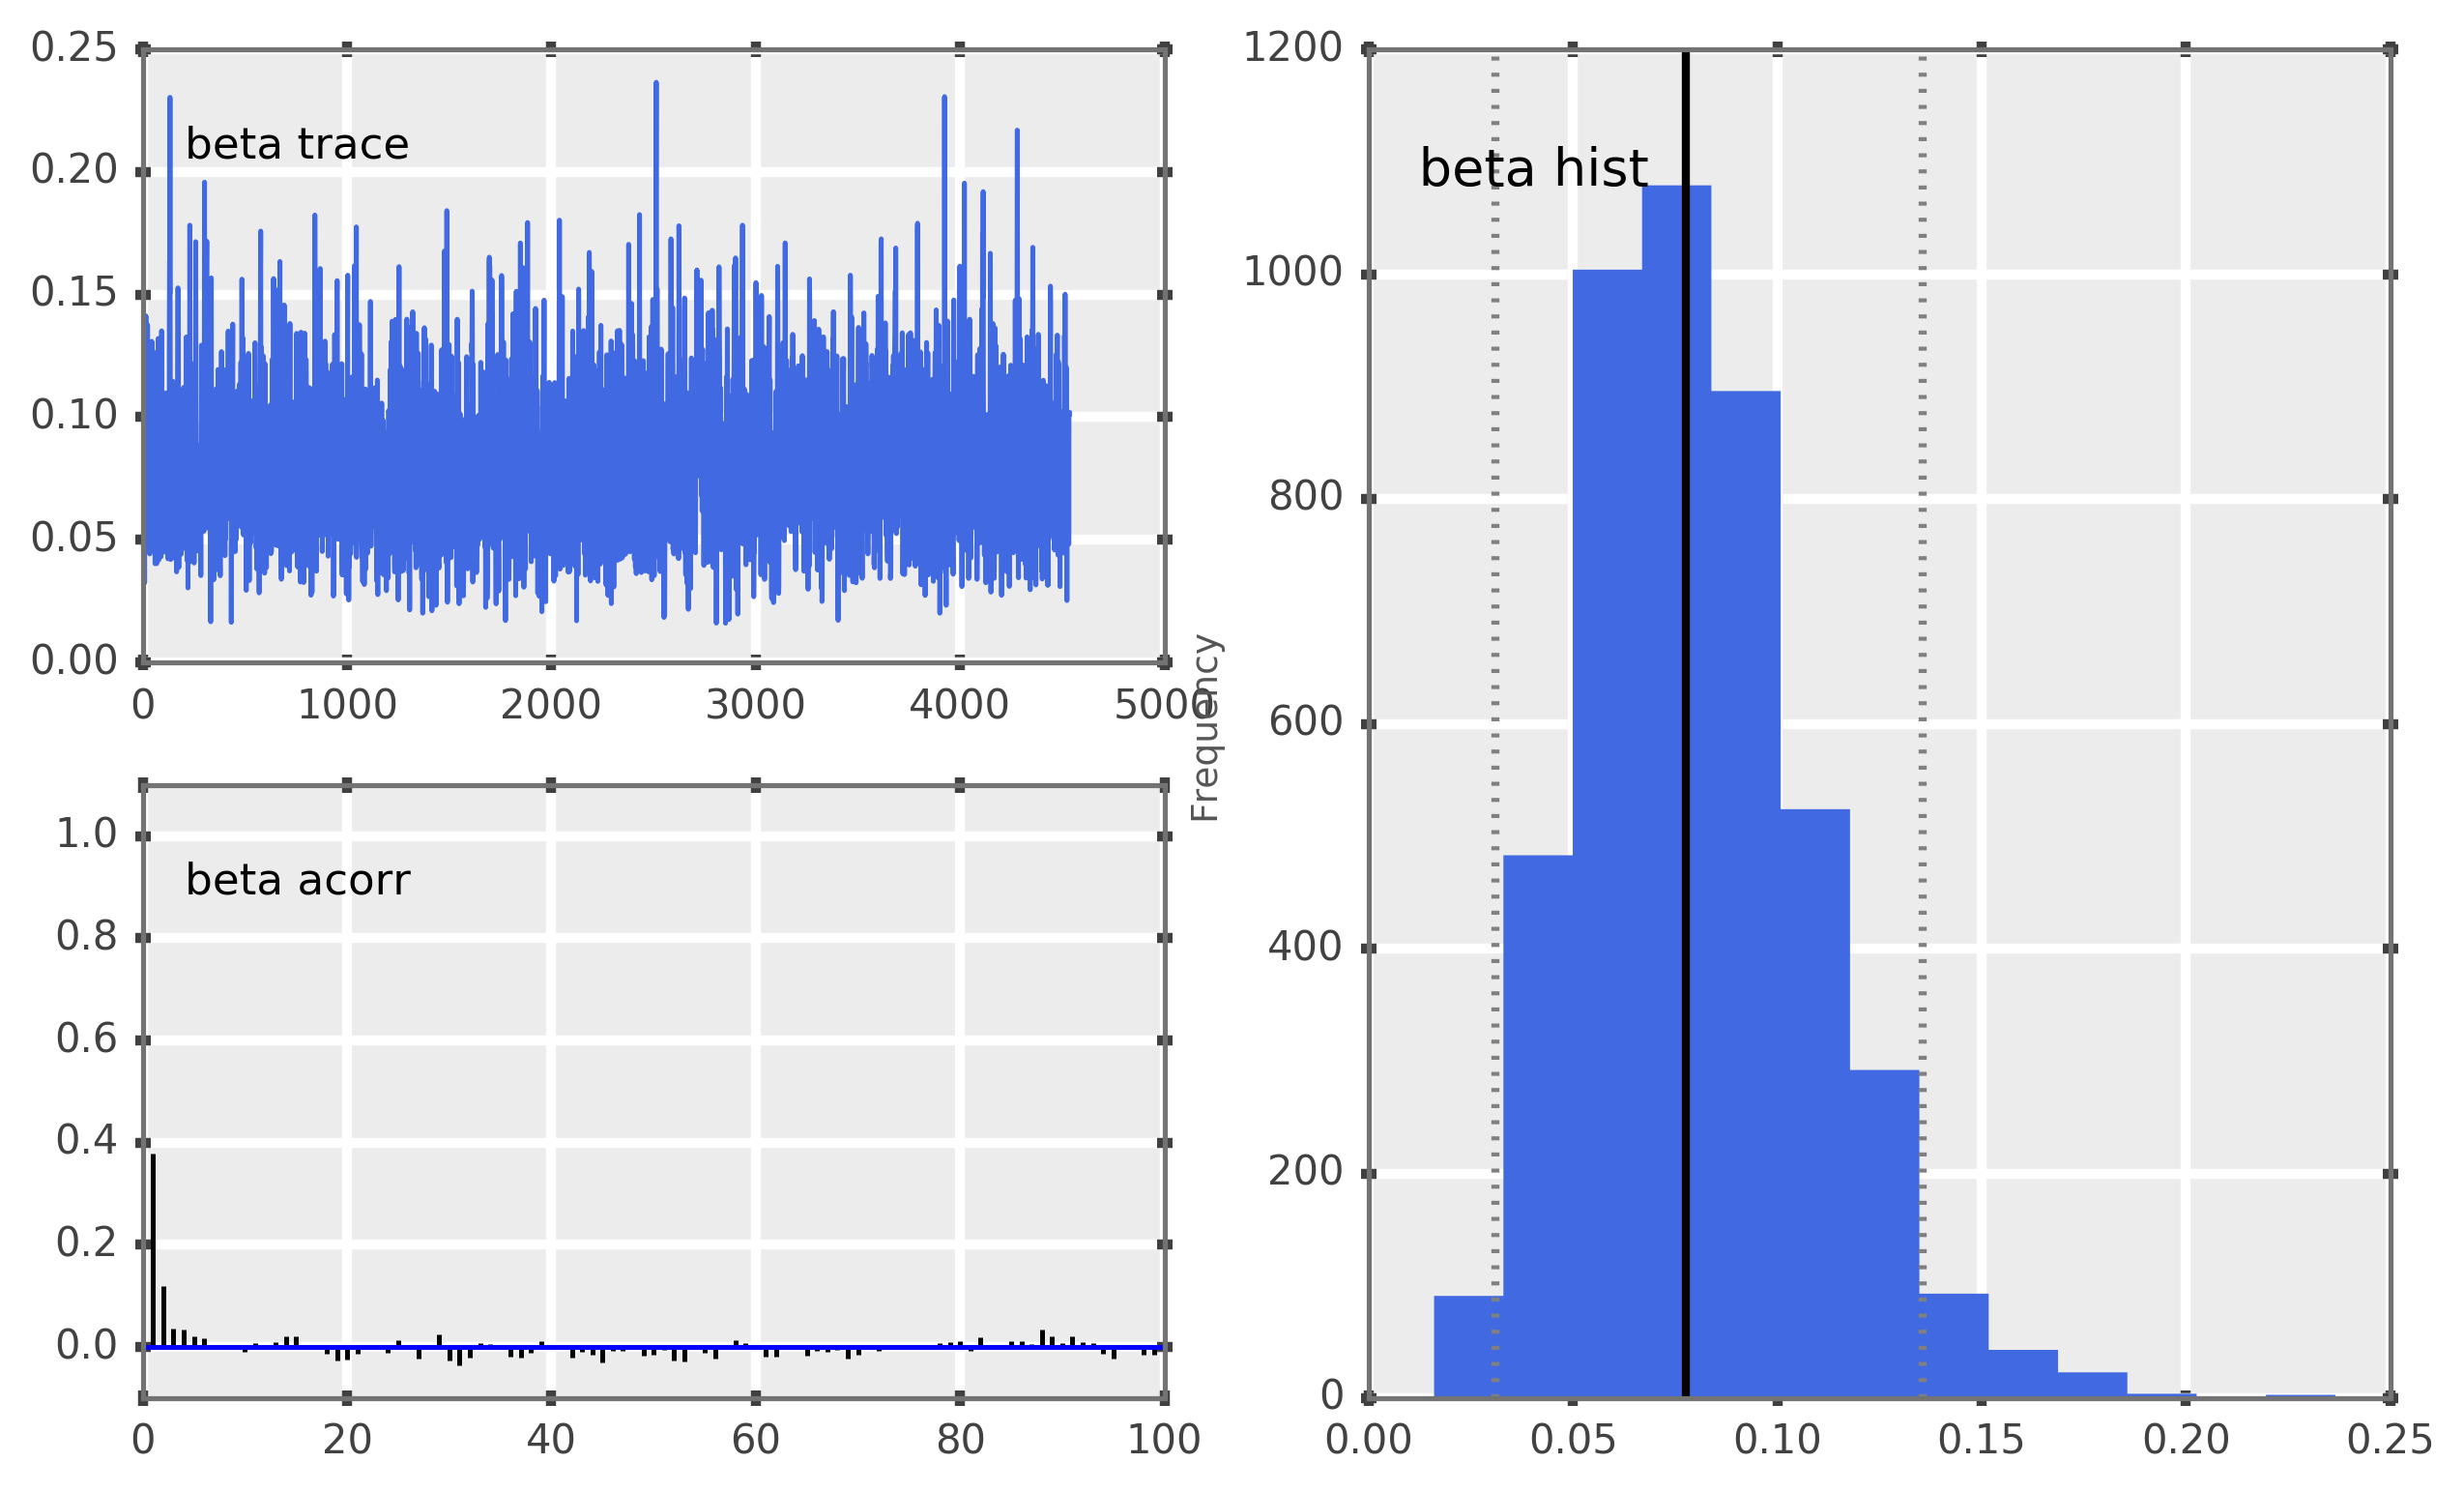

In [20]:
pymc.Matplot.plot(mc)
pprint(mc.stats())

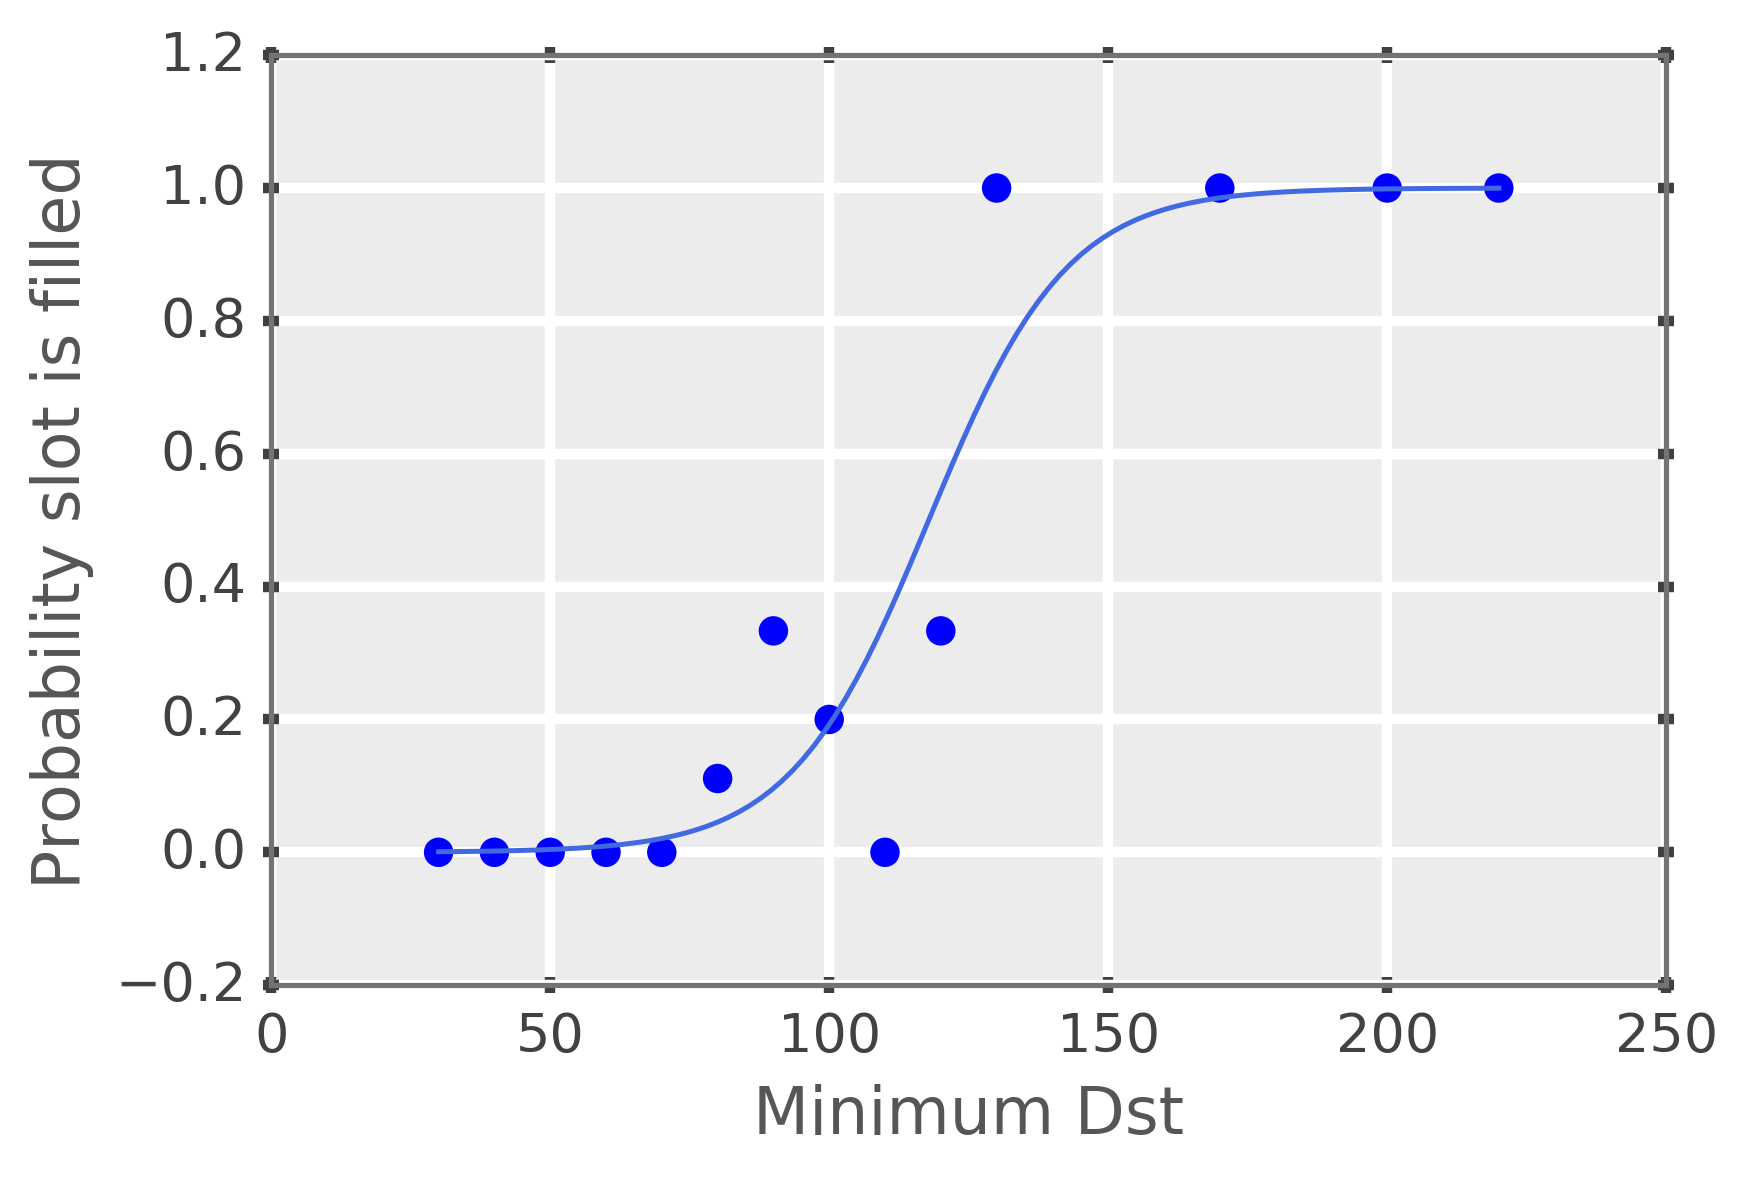

In [21]:
xp = np.linspace(dst_bins_centers[ind].min(), dst_bins_centers[ind].max(), 100)
a = alpha.stats()['mean']
b = beta.stats()['mean']
y_val = invlogit(a + b*xp).value
plt.plot(xp, y_val)
plt.scatter(dst_bins_centers[ind], success[ind]/n_events[ind], s=50);
plt.xlabel('Minimum Dst')
plt.ylabel('Probability slot is filled')
plt.gca().ticklabel_format(useOffset=False)


In [22]:
# get the minimum Dst where 99% should be successes
for percentage in [1, 25, 50,75,90,95,99]:
    ind99 = y_val >= percentage/100
    minDst99 = xp[ind99][0]
    print('At a minimum Dst of {0:0.0f}nT it is predicted to have a {1}% percent of a slot filling'.format(minDst99, percentage))

At a minimum Dst of 63nT it is predicted to have a 1% percent of a slot filling
At a minimum Dst of 105nT it is predicted to have a 25% percent of a slot filling
At a minimum Dst of 118nT it is predicted to have a 50% percent of a slot filling
At a minimum Dst of 132nT it is predicted to have a 75% percent of a slot filling
At a minimum Dst of 145nT it is predicted to have a 90% percent of a slot filling
At a minimum Dst of 155nT it is predicted to have a 95% percent of a slot filling
At a minimum Dst of 176nT it is predicted to have a 99% percent of a slot filling


In [23]:
# one should be able to get estimates of the line uncertainity
ilu = np.empty((1000, len(xp)), dtype=float)
for ii, v in enumerate(np.random.random_integers(0, len(alpha.trace[:])-1, 1000)):
  ilu[ii] = invlogit(alpha.trace[:][v] + beta.trace[:][v]*xp).value


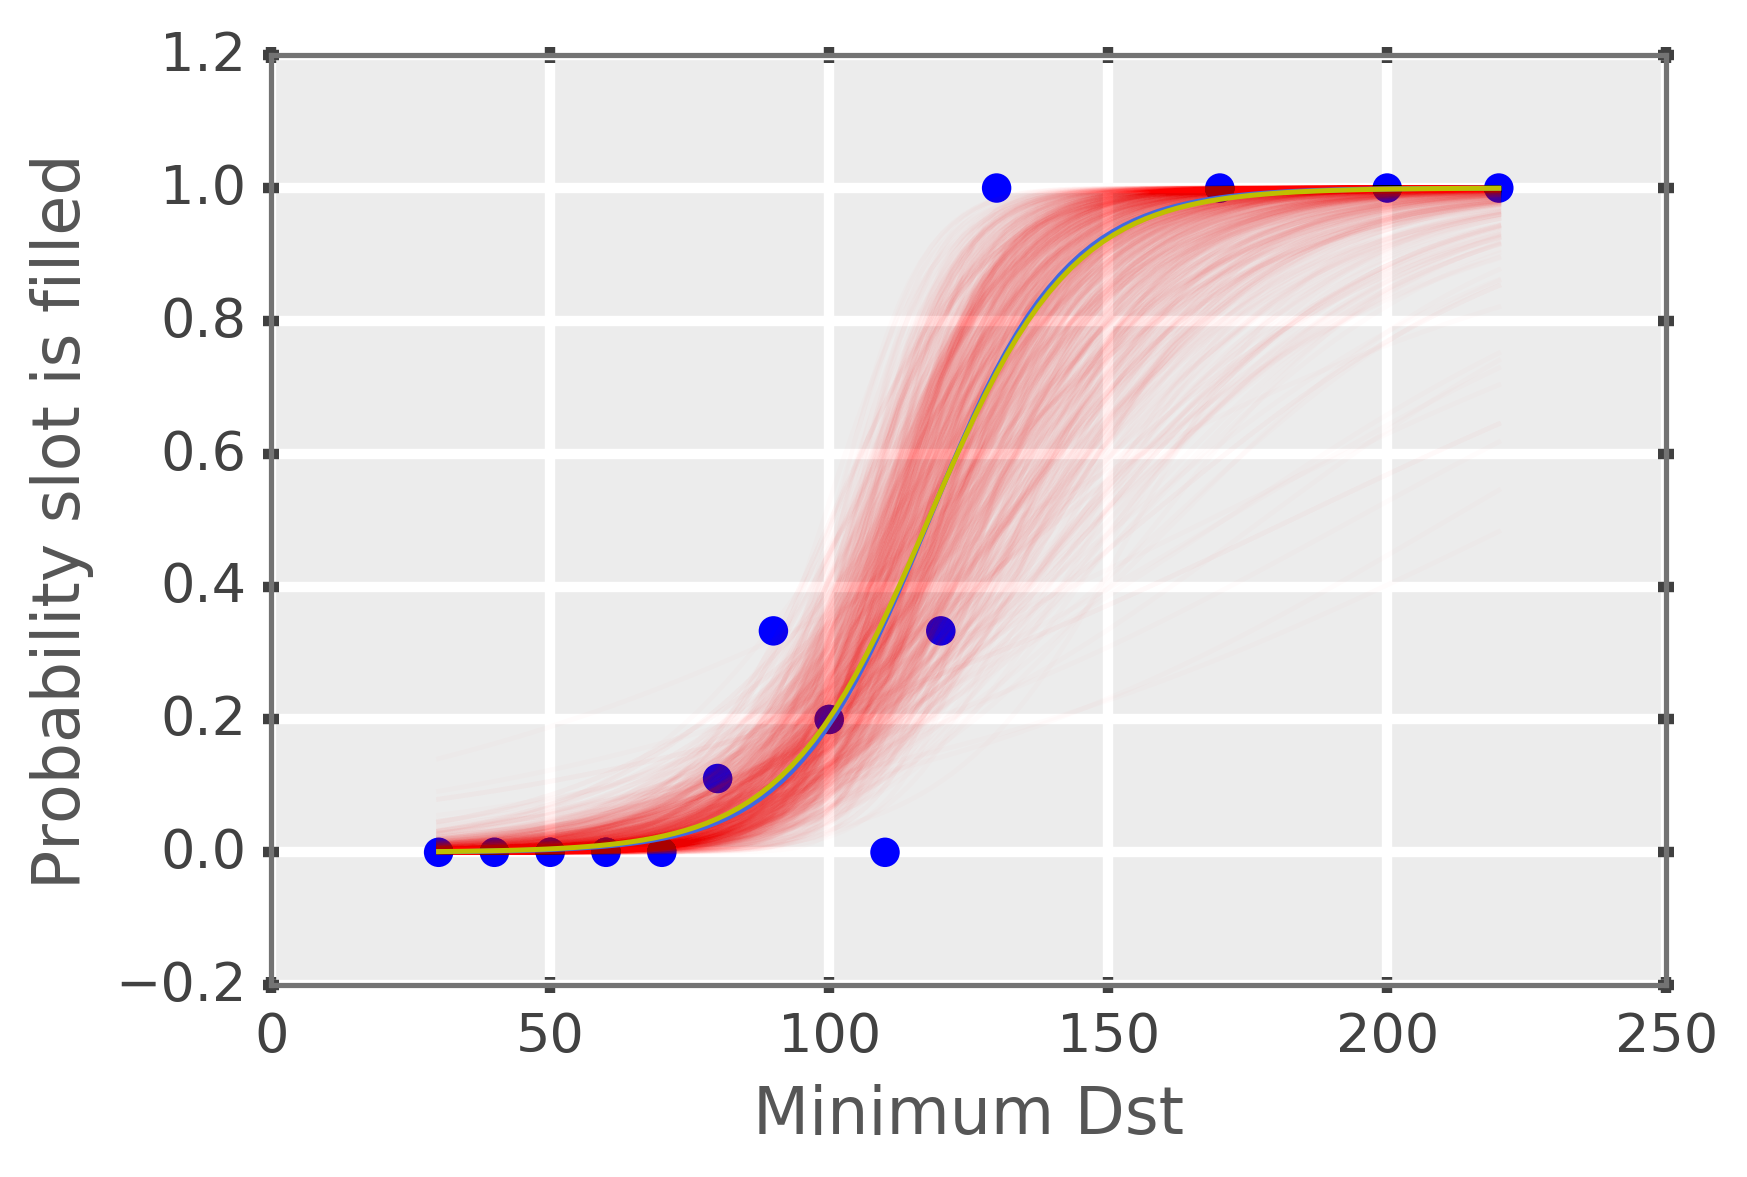

In [24]:
xp = np.linspace(dst_bins_centers[ind].min(), dst_bins_centers[ind].max(), 100)
for v in ilu:
  plt.plot(xp, v, alpha=.01, c='r')


a = alpha.stats()['mean']
b = beta.stats()['mean']
plt.plot(xp, invlogit(a + b*xp).value)

a = alpha.stats()['quantiles'][50]
b = beta.stats()['quantiles'][50]
plt.plot(xp, invlogit(a + b*xp).value, c='y')


plt.scatter(dst_bins_centers[ind], success[ind]/n_events[ind], s=50);
plt.xlabel('Minimum Dst')
plt.ylabel('Probability slot is filled')

# Do the analysis again in Dst bins (25nT)



In [25]:
# make bins in Dst
dst_bins = np.arange(25, 300, 25)
print(dst_bins)
dst_bins_centers = np.asarray([dst_bins[:-1] + np.diff(dst_bins)/2]).T[:,0]
print(dst_bins_centers, dst_bins_centers.shape)
n_events_dig = np.digitize(dst, dst_bins)
print(n_events_dig)
n_events = np.zeros(len(dst_bins)-1)
success = np.zeros_like(n_events)
for i, v in enumerate(np.unique(n_events_dig)):
    n_events[v-1] = np.sum(n_events_dig==v)
    success[v-1] = np.sum(minL[n_events_dig==v] <= 2.3)
print(n_events)
print(success)


[ 25  50  75 100 125 150 175 200 225 250 275]
[  37.5   62.5   87.5  112.5  137.5  162.5  187.5  212.5  237.5  262.5] (10,)
[2 2 5 2 2 2 4 2 3 2 1 2 2 3 2 4 3 3 2 1 3 3 2 3 1 2 8 3 3 2 8 2 2 2 3 3 3
 3 4 3 2 6 4 3 2 3 2 1 3]
[  4.  20.  17.   4.   1.   1.   0.   2.   0.   0.]
[ 0.  0.  3.  1.  1.  1.  0.  2.  0.  0.]


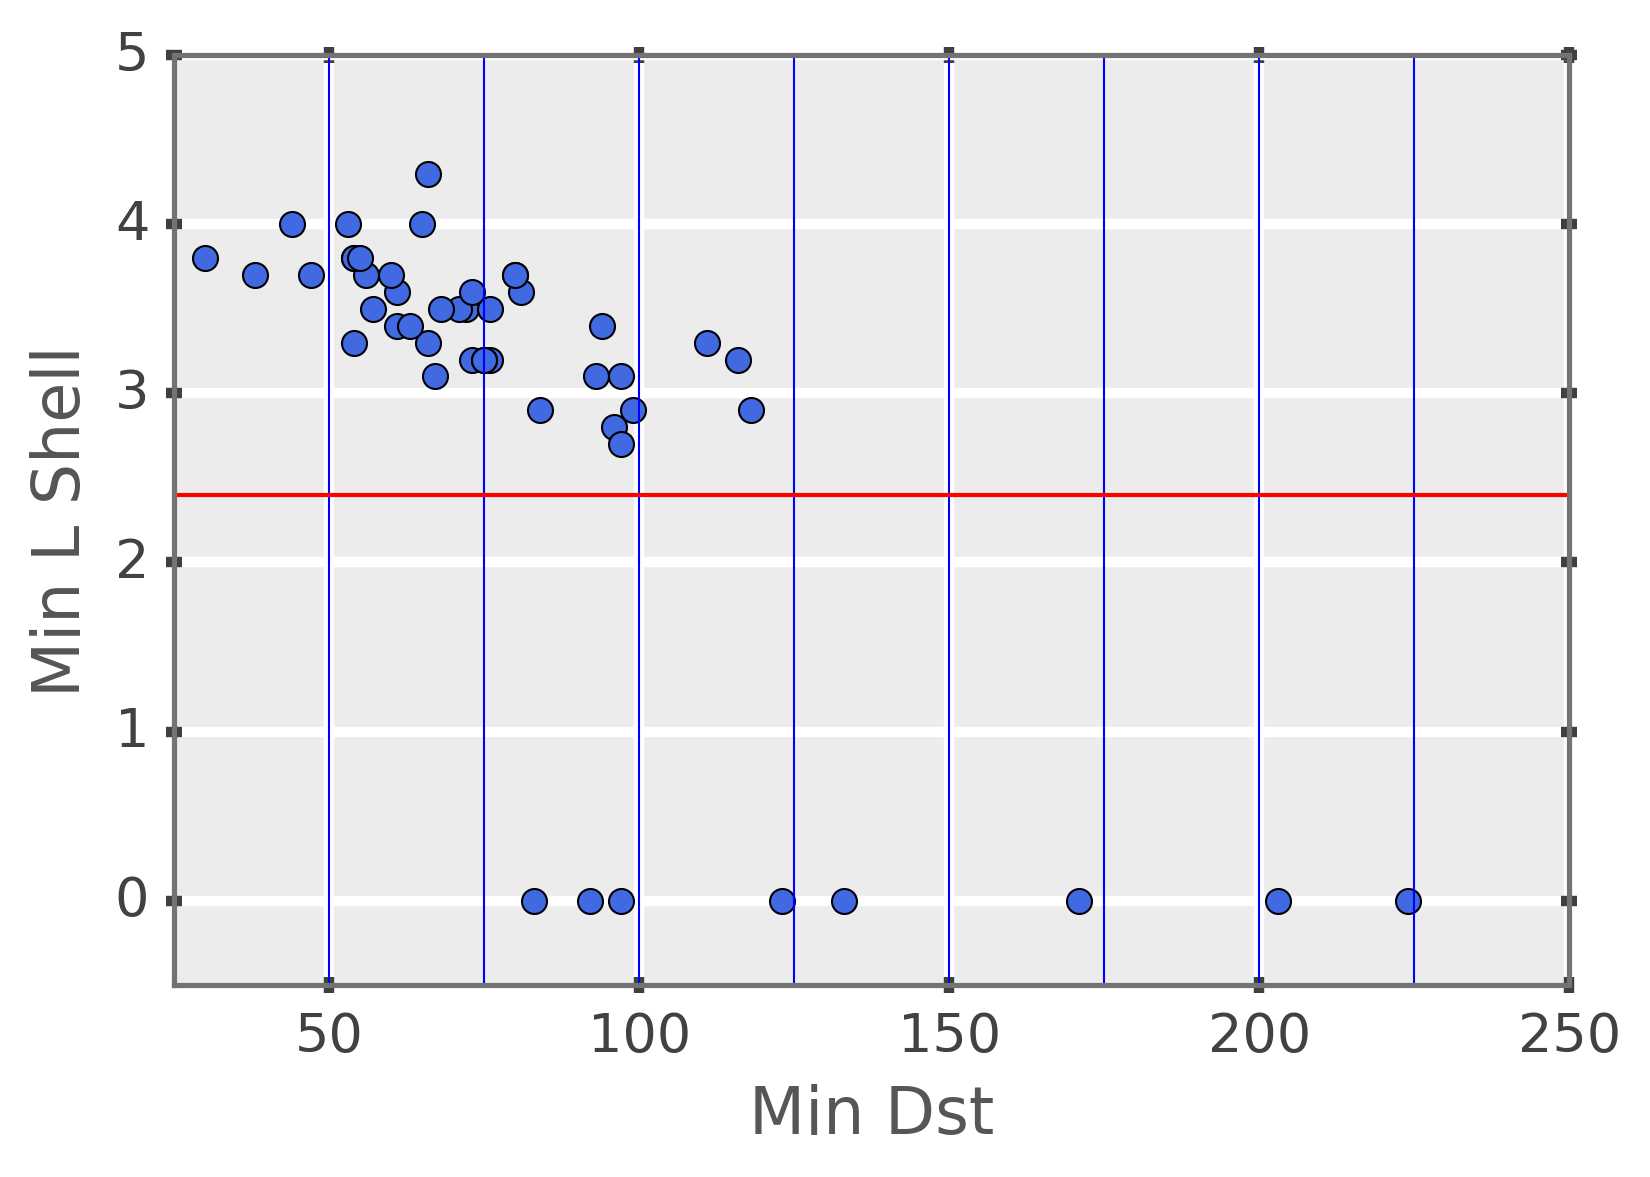

In [26]:
plt.plot(dst, minL, 'o')
plt.xlim((25, 250))
plt.ylim((-0.5, 5.0))
plt.xlabel('Min Dst')
plt.ylabel('Min L Shell')
for v in dst_bins:
    plt.axvline(v, lw=0.5)
plt.axhline(2.4, c='r', lw=1)

In [27]:
# define priors
# these are wide uninformative priors
# alpha = pymc.Normal('alpha', mu=0, tau=1.0/5**2)
# beta = pymc.Normal('beta', mu=0, tau=1.0/10**2)
alpha = pymc.Uniform('alpha', -500, 100, value = 1e-2)
beta = pymc.Uniform('beta', -100, 100, value = 1e-2)


# cannot feed in zero events
ind = n_events > 0
print(n_events.shape, dst_bins_centers.shape, success.shape, )

# define likelihood
p = pymc.InvLogit('p', alpha + beta*dst_bins_centers[ind])
print('n_events', n_events[ind], 'p', p.value, 'success', success[ind], )
y = pymc.Binomial('y_obs', n=n_events[ind], p=p, value=success[ind], observed=True)



(10,) (10,) (10,)
n_events [  4.  20.  17.   4.   1.   1.   2.] p [ 0.59507847  0.65362233  0.70785727  0.75676045  0.79979282  0.83685344
  0.89425874] success [ 0.  0.  3.  1.  1.  1.  2.]


In [28]:
# inference
m = pymc.Model([alpha, beta, y])
mc = pymc.MCMC(m)
mc.sample(iter=500000, burn=1000, burn_till_tuned=True, thin=110)

 [-----------------102%-----------------] 514521 of 504000 complete in 56.0 sec

Plotting alpha
Plotting beta
{'alpha': {'95% HPD interval': array([-16.17551071,  -4.81002005]),
           'mc error': 0.070534832054253996,
           'mean': -9.9834678273043753,
           'n': 4536,
           'quantiles': {2.5: -16.920221909514005,
                         25: -11.768537161472496,
                         50: -9.5850653755596316,
                         75: -7.792558603122492,
                         97.5: -5.2242412084362},
           'standard deviation': 3.039181062440599},
 'beta': {'95% HPD interval': array([ 0.0360748,  0.1536126]),
          'mc error': 0.00071099457172278571,
          'mean': 0.088338300940054057,
          'n': 4536,
          'quantiles': {2.5: 0.039044866861897821,
                        25: 0.065710496195836951,
                        50: 0.084482072483812135,
                        75: 0.10635083444135796,
                        97.5: 0.15941433628399482},
          'standard deviation': 0.031065574163275968}}


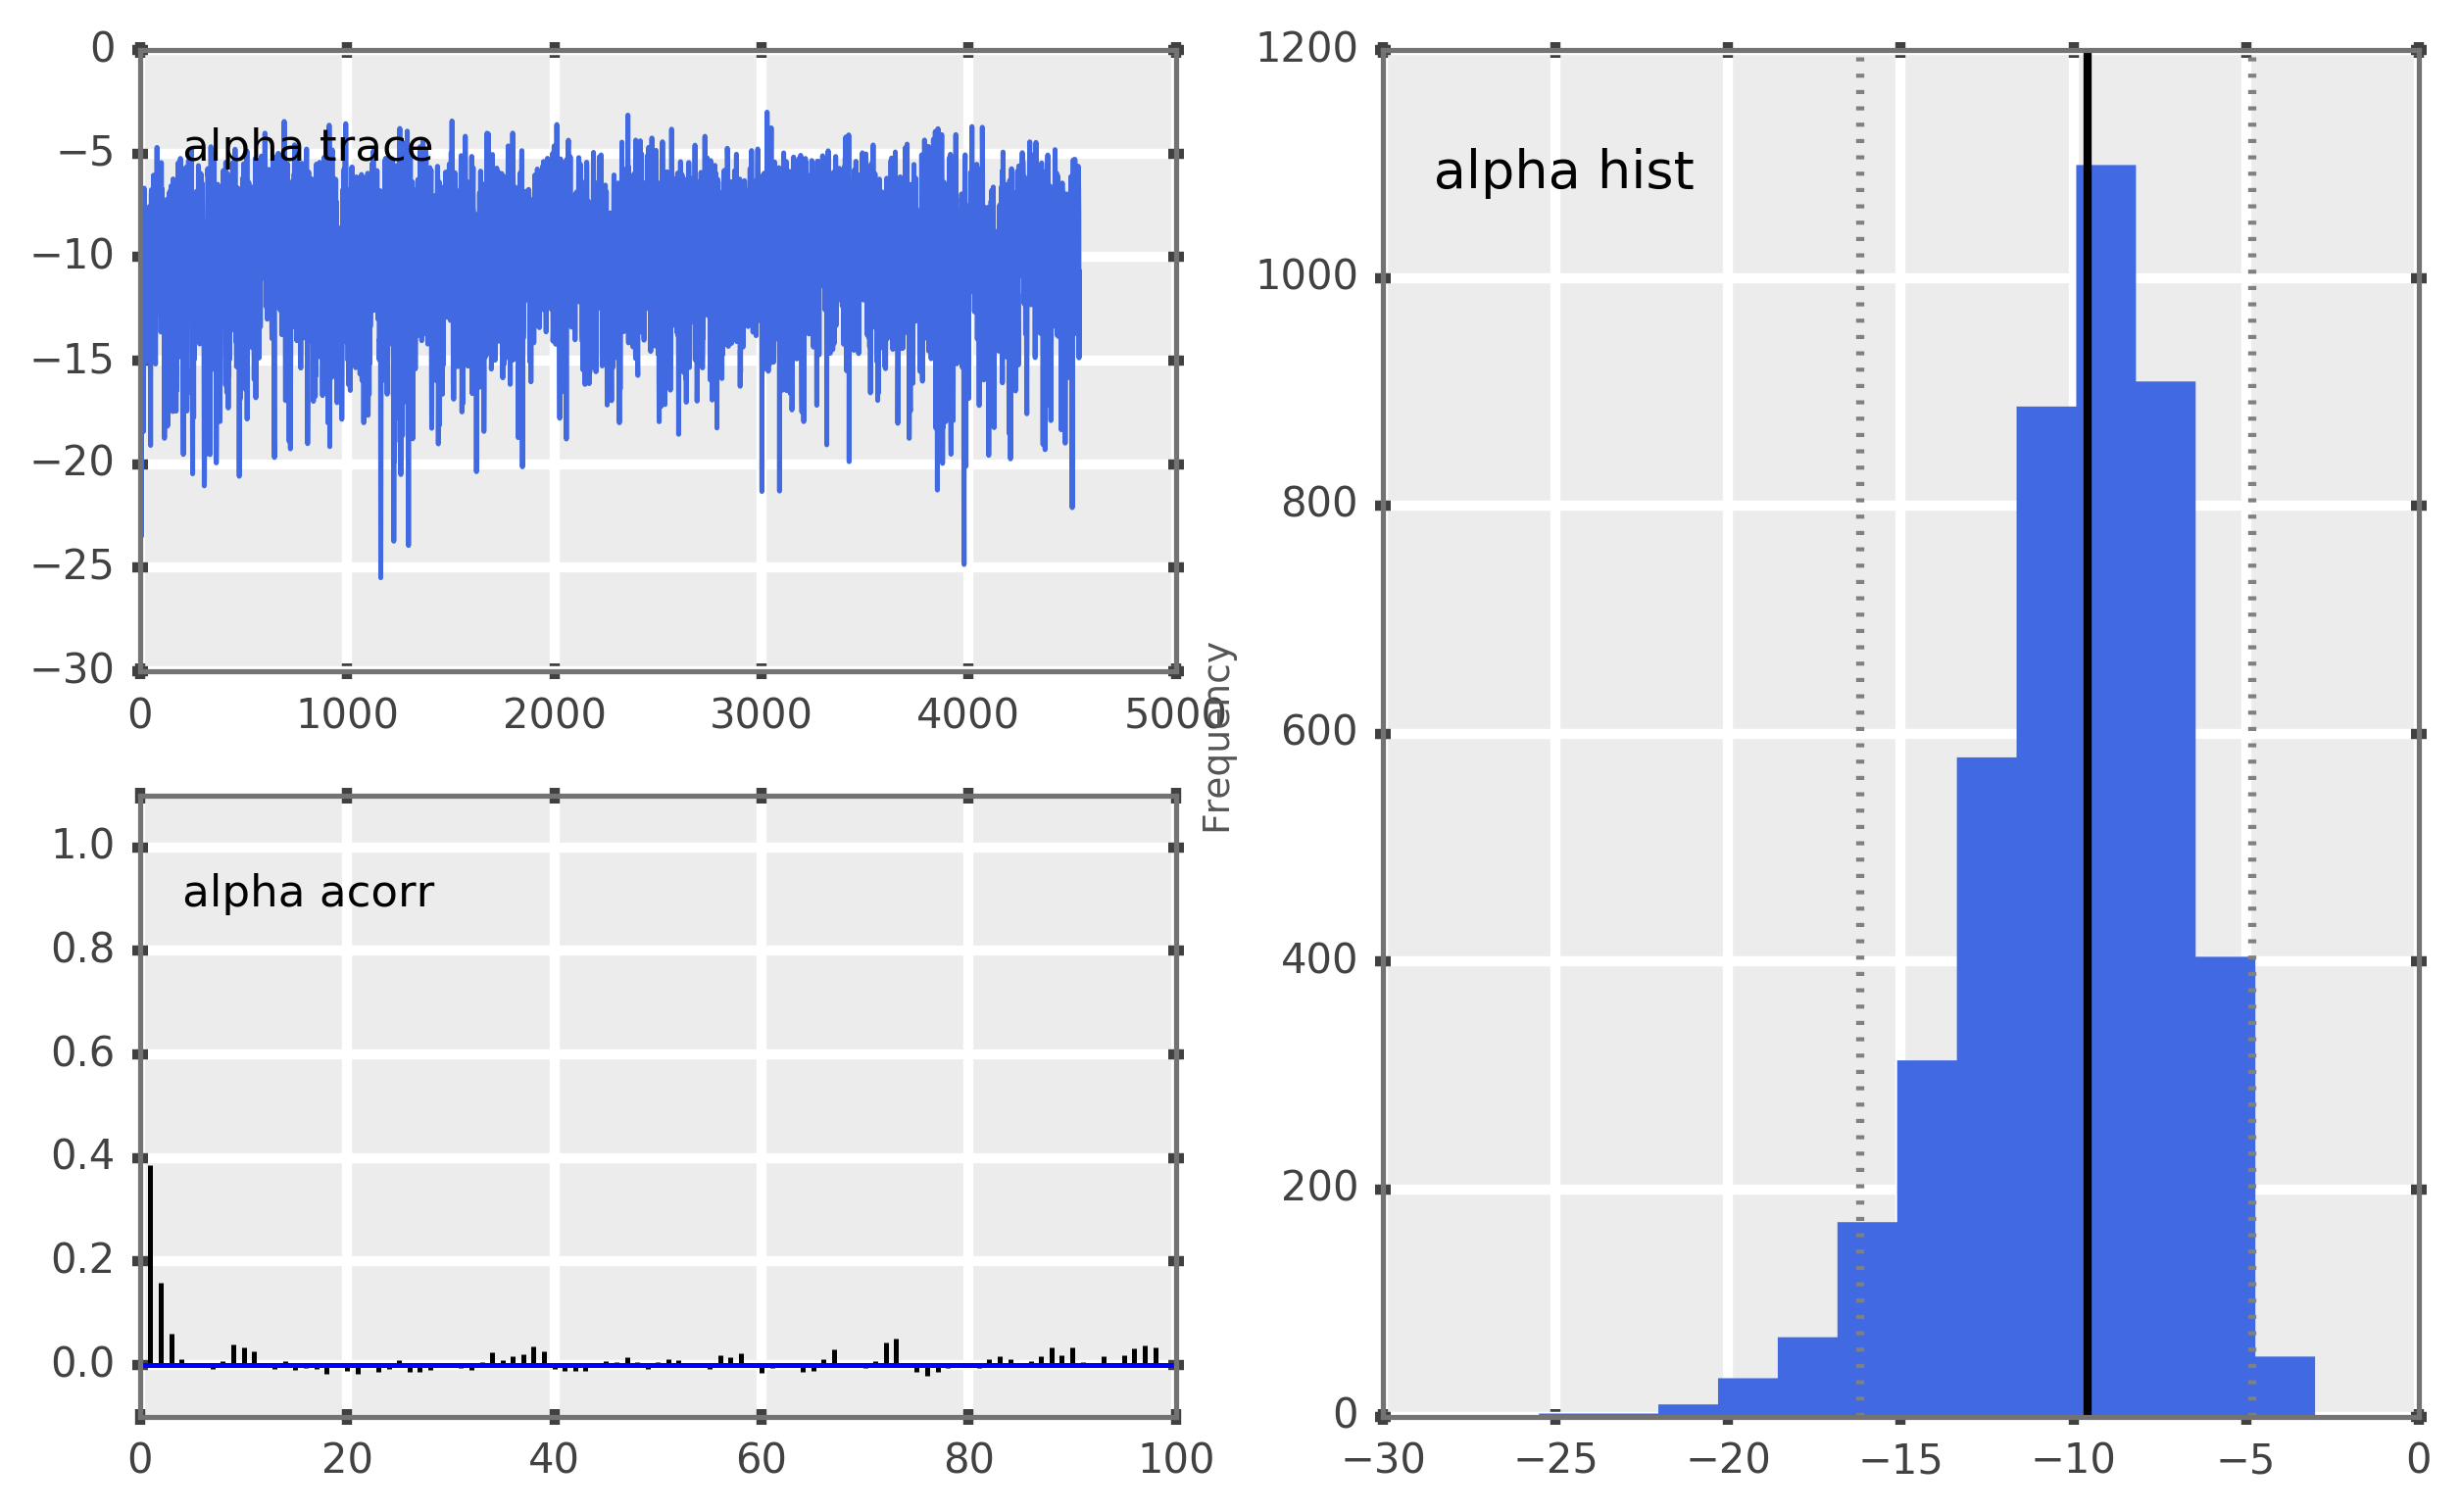

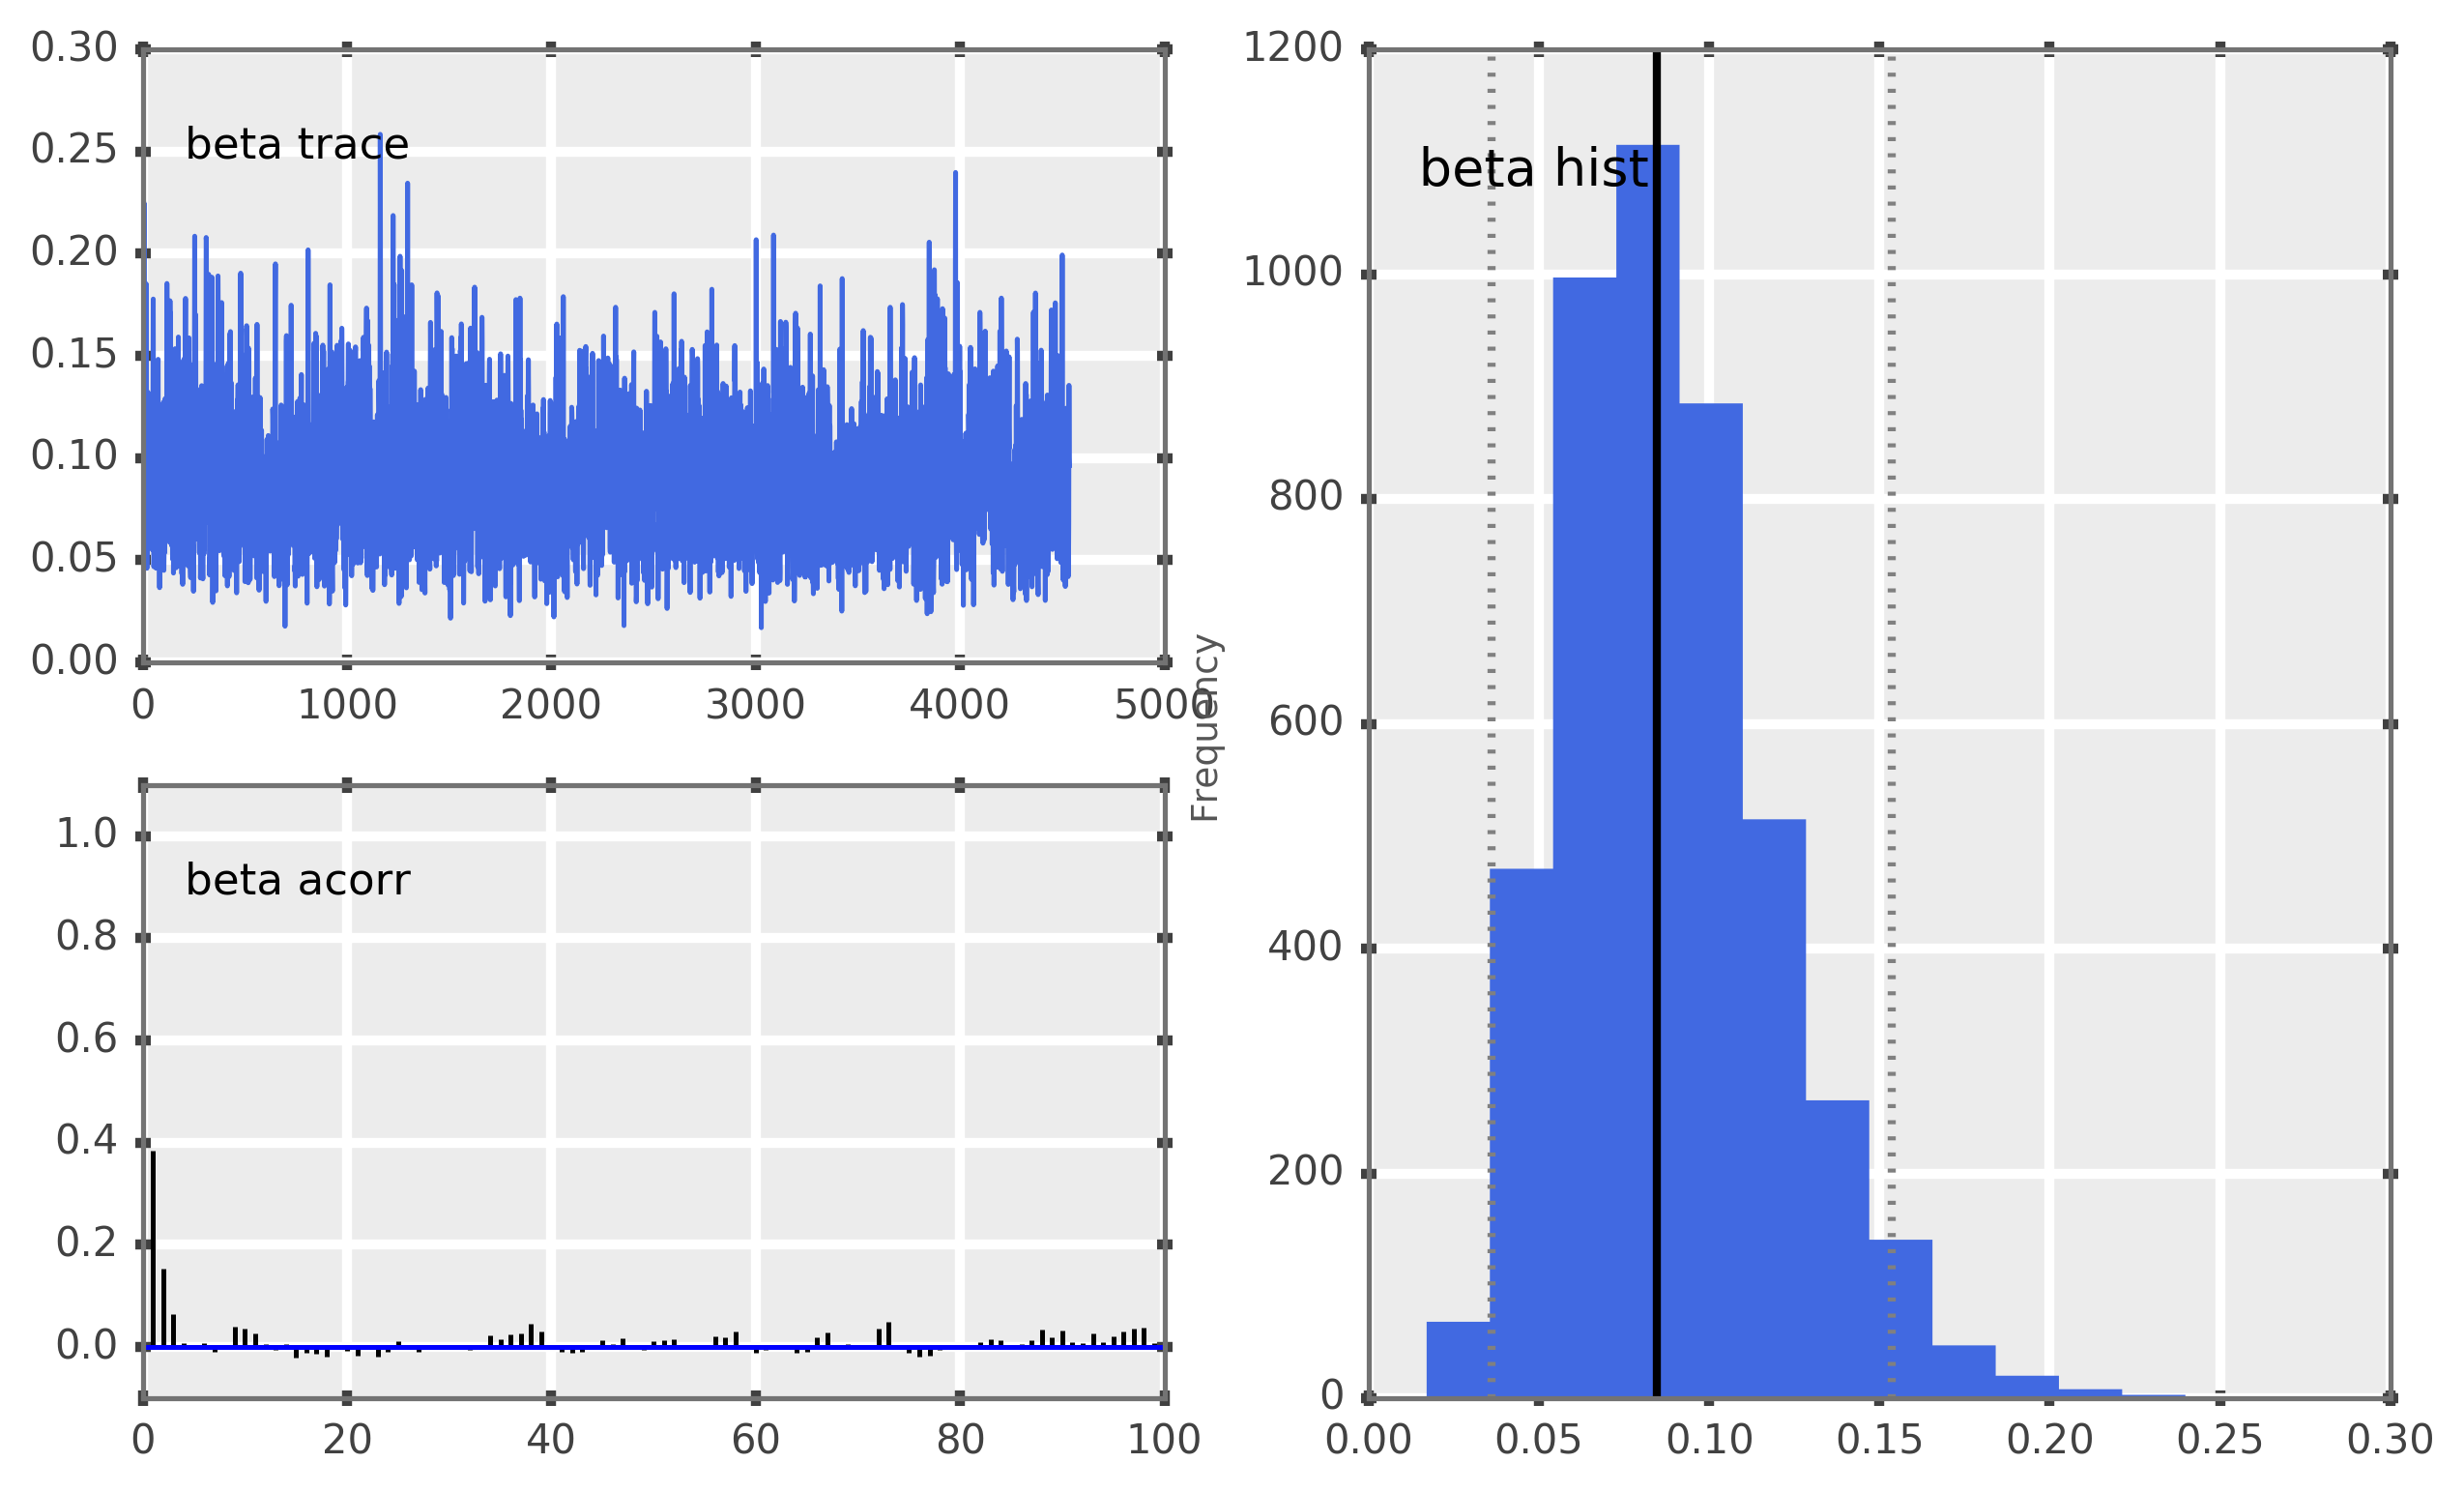

In [29]:
pymc.Matplot.plot(mc)
pprint(mc.stats())

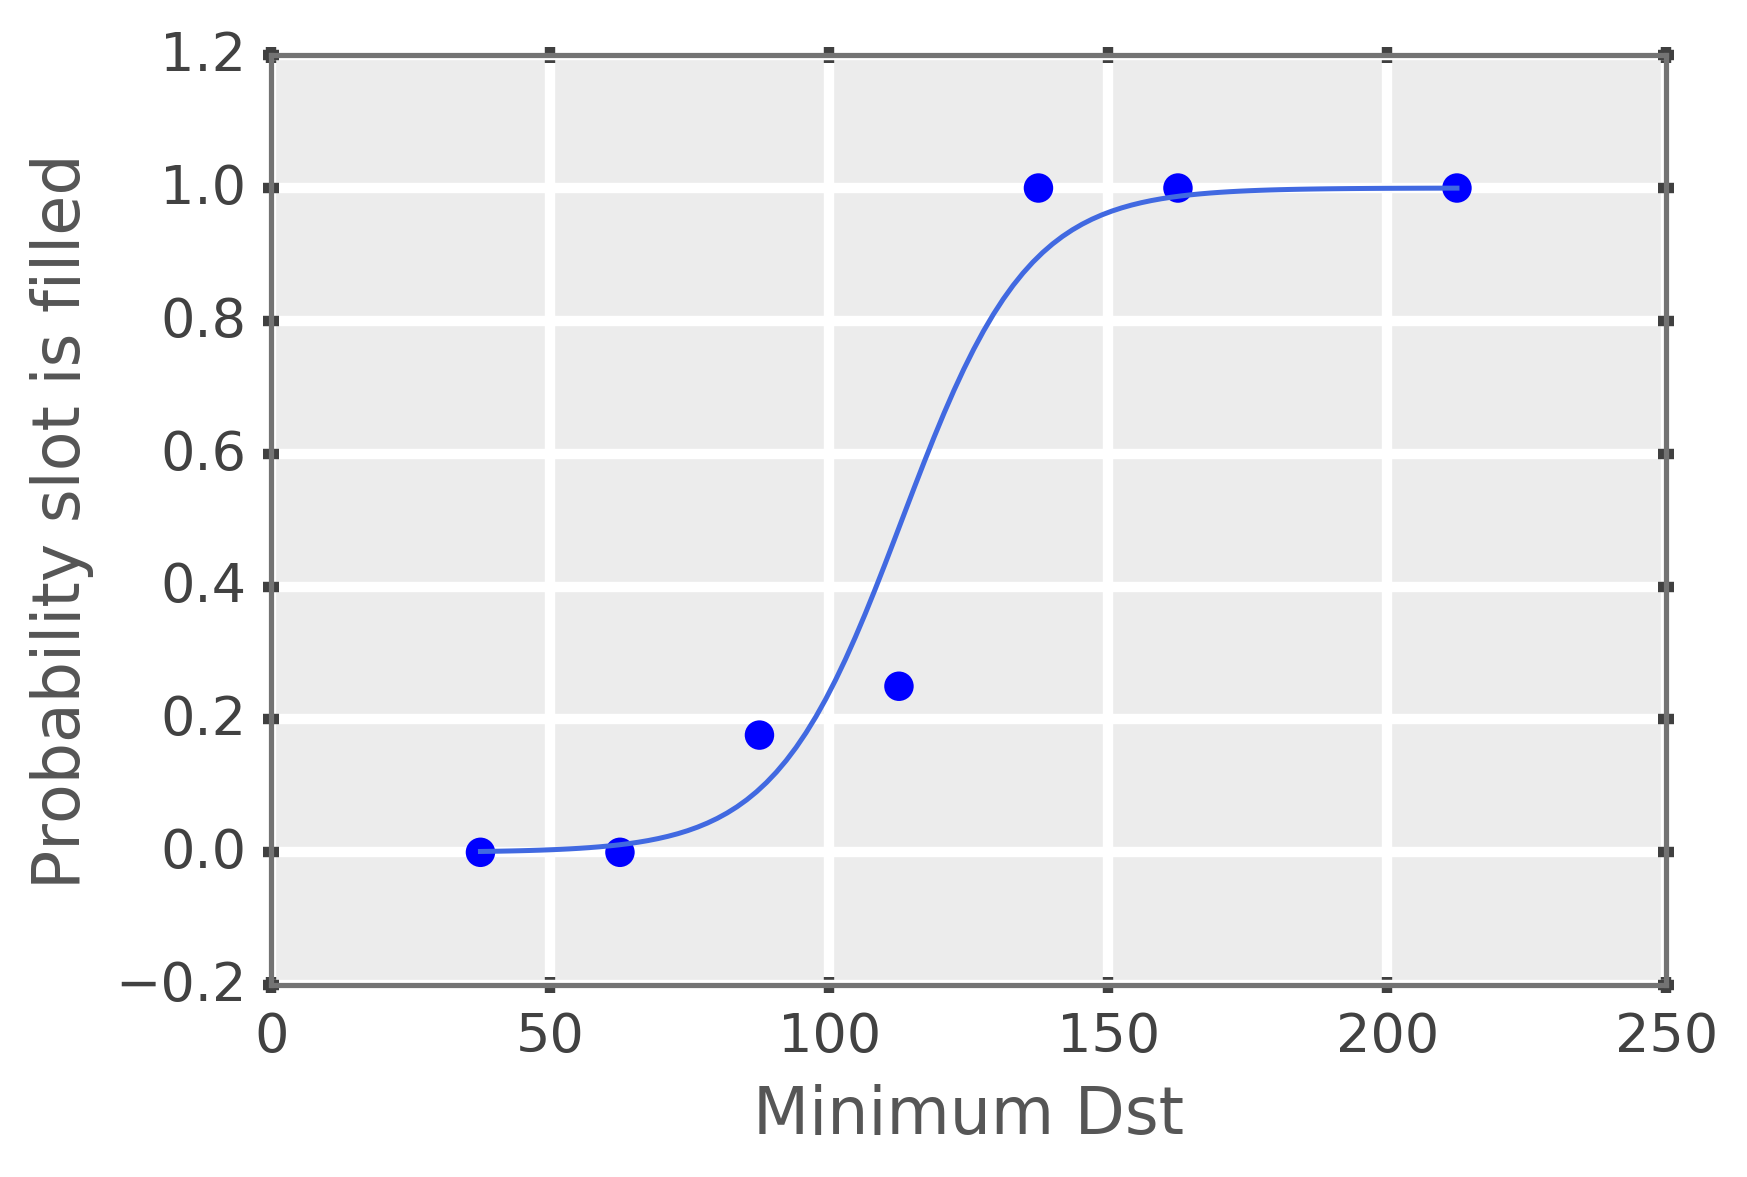

In [30]:
xp = np.linspace(dst_bins_centers[ind].min(), dst_bins_centers[ind].max(), 100)
a = alpha.stats()['mean']
b = beta.stats()['mean']
y_val = invlogit(a + b*xp).value
plt.plot(xp, y_val)
plt.scatter(dst_bins_centers[ind], success[ind]/n_events[ind], s=50);
plt.xlabel('Minimum Dst')
plt.ylabel('Probability slot is filled')
plt.gca().ticklabel_format(useOffset=False)


In [31]:
# get the minimum Dst where 99% should be successes
for percentage in [1, 25, 50,75,90,95,99]:
    ind99 = y_val >= percentage/100
    minDst99 = xp[ind99][0]
    print('At a minimum Dst of {0:0.0f}nT it is predicted to have a {1}% percent of a slot filling'.format(minDst99, percentage))

At a minimum Dst of 62nT it is predicted to have a 1% percent of a slot filling
At a minimum Dst of 101nT it is predicted to have a 25% percent of a slot filling
At a minimum Dst of 114nT it is predicted to have a 50% percent of a slot filling
At a minimum Dst of 126nT it is predicted to have a 75% percent of a slot filling
At a minimum Dst of 138nT it is predicted to have a 90% percent of a slot filling
At a minimum Dst of 147nT it is predicted to have a 95% percent of a slot filling
At a minimum Dst of 167nT it is predicted to have a 99% percent of a slot filling


In [32]:
# one should be able to get estimates of the line uncertainity
ilu = np.empty((1000, len(xp)), dtype=float)
for ii, v in enumerate(np.random.random_integers(0, len(alpha.trace[:])-1, 1000)):
  ilu[ii] = invlogit(alpha.trace[:][v] + beta.trace[:][v]*xp).value


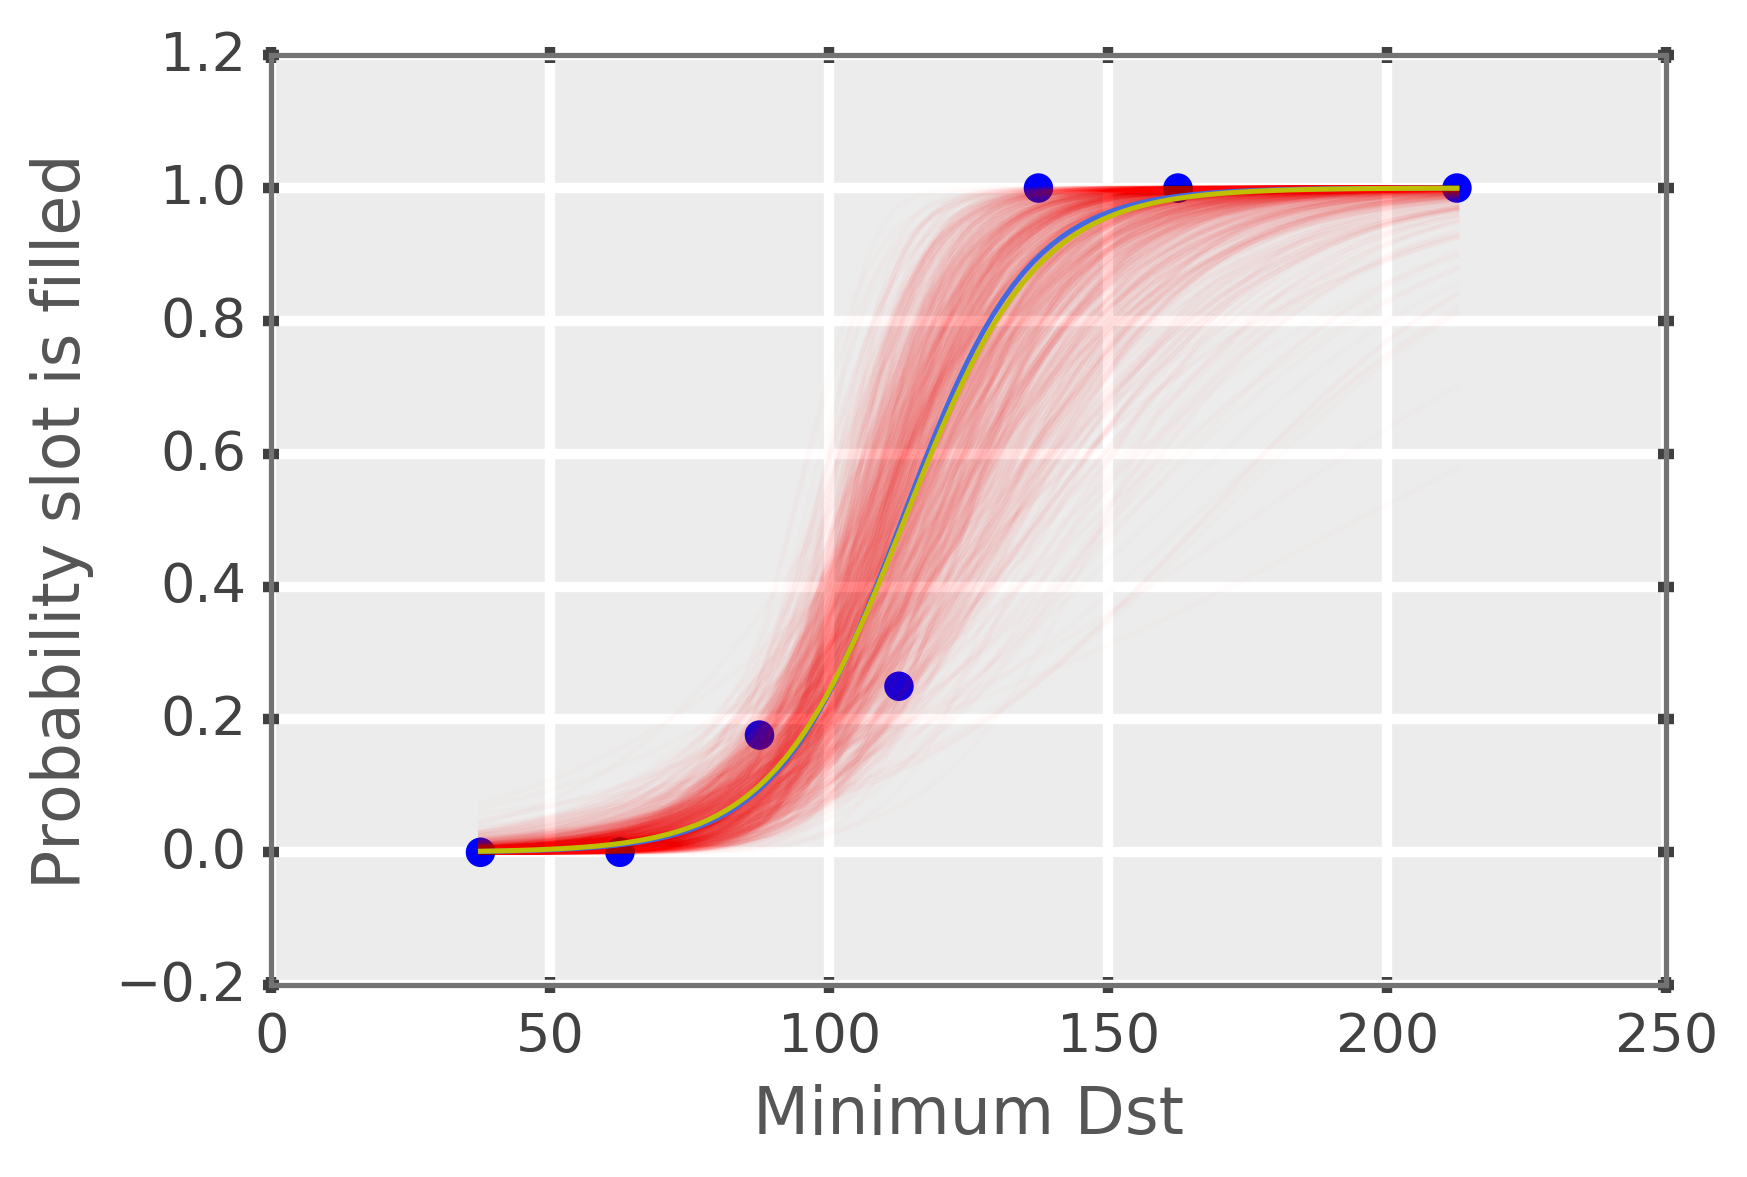

In [33]:
xp = np.linspace(dst_bins_centers[ind].min(), dst_bins_centers[ind].max(), 100)
for v in ilu:
  plt.plot(xp, v, alpha=.01, c='r')


a = alpha.stats()['mean']
b = beta.stats()['mean']
plt.plot(xp, invlogit(a + b*xp).value)

a = alpha.stats()['quantiles'][50]
b = beta.stats()['quantiles'][50]
plt.plot(xp, invlogit(a + b*xp).value, c='y')


plt.scatter(dst_bins_centers[ind], success[ind]/n_events[ind], s=50);
plt.xlabel('Minimum Dst')
plt.ylabel('Probability slot is filled')